In [1]:
import chimeralm
import matplotlib.pyplot as plt
import numpy as np
import torch
from chimeralm.data.tokenizer import load_tokenizer_from_hyena_model
import pandas as pd

In [2]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [3]:
torch.cuda.is_available()

False

In [6]:
torch.__version__

'2.5.1'

# Code

In [ ]:
class AttentionVisualizer:
    def __init__(self):
        self.model = chimeralm.models.ChimeraLM.from_pretrained("yangliz5/chimeralm", save_attention=True)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.eval()
        self.model.to(self.device)
        self.tokenizer = load_tokenizer_from_hyena_model("hyenadna-small-32k-seqlen")

    def attention_weights(self, sequence):
        tokenized = self.tokenizer(sequence, truncation=True, padding=True, max_length=32768, return_tensors="pt")
        input_ids = tokenized["input_ids"].to(self.device)
        input_quals = None  # We don't have quality scores for web input
        with torch.no_grad():
            logits = self.model(input_ids, input_quals)
            probabilities = torch.softmax(logits, dim=-1)
            predicted_class = torch.argmax(probabilities, dim=-1).item()
            confidence = probabilities[0][predicted_class].item()

        confidence_breakdown = {
            "Biological": f"{probabilities[0][0].item():.3f}",
            "Chimeric Artifact": f"{probabilities[0][1].item():.3f}",
        }

        print(confidence_breakdown)

        # Check if attention weights exist and handle potential errors
        if not hasattr(self.model.net.head, "attention_weights") or self.model.net.head.attention_weights is None:
            raise ValueError("Attention weights not available. Make sure the model was loaded with save_attention=True")

        # Get attention weights and convert to CPU/numpy for visualization
        attention_weights = self.model.net.head.attention_weights.squeeze(dim=(0, -1))
        if attention_weights.is_cuda:
            attention_weights = attention_weights.cpu()

        return probabilities, attention_weights

    def visualize(self, sequence, *args, **kwargs):
        import matplotlib.pyplot as plt

        # Get the attention weights for the last layer
        weights = self.attention_weights(sequence)[1]

        # Convert to numpy if it's a tensor
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()

        # Remove special tokens (CLS token at the beginning)
        # The tokenizer adds [CLS] token at position 0, so we skip it
        weights = weights[:-1]

        # Ensure we have the right number of weights for the sequence
        if len(weights) != len(sequence):
            print(f"Warning: Sequence length ({len(sequence)}) doesn't match attention weights length ({len(weights)})")
            # Take the minimum to avoid index errors
            min_len = min(len(weights), len(sequence))
            weights = weights[:min_len]
            sequence = sequence[:min_len]

        # Create the plot
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(sequence)), weights, "b-", linewidth=2, marker="o", markersize=4, *args, **kwargs)
        plt.xticks(range(len(sequence)), list(sequence), fontsize=12)
        plt.xlabel("Sequence Position", fontsize=14)
        plt.ylabel("Attention Weight", fontsize=14)
        plt.title("Attention Weights Visualization", fontsize=16, fontweight="bold")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return weights

    def visualize_bar(self, sequence, *args, **kwargs):
        import matplotlib.pyplot as plt

        # Get the attention weights for the last layer
        weights = self.attention_weights(sequence)[1]

        # Convert to numpy if it's a tensor
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()

        # Remove special tokens (CLS token at the beginning)
        # The tokenizer adds [CLS] token at position 0, so we skip it
        weights = weights[:-1]

        # Ensure we have the right number of weights for the sequence
        if len(weights) != len(sequence):
            print(f"Warning: Sequence length ({len(sequence)}) doesn't match attention weights length ({len(weights)})")
            # Take the minimum to avoid index errors
            min_len = min(len(weights), len(sequence))
            weights = weights[:min_len]
            sequence = sequence[:min_len]

        # Create the plot
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(sequence)), weights, linewidth=2, *args, **kwargs)
        plt.xticks(range(len(sequence)), list(sequence), fontsize=12)
        plt.xlabel("Sequence Position", fontsize=14)
        plt.ylabel("Attention Weight", fontsize=14)
        plt.title("Attention Weights Visualization", fontsize=16, fontweight="bold")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return weights

In [11]:
sequence = "ATCGCGTG"

In [12]:
atten_vis = AttentionVisualizer()

{'Biological': '0.973', 'Chimeric Artifact': '0.027'}


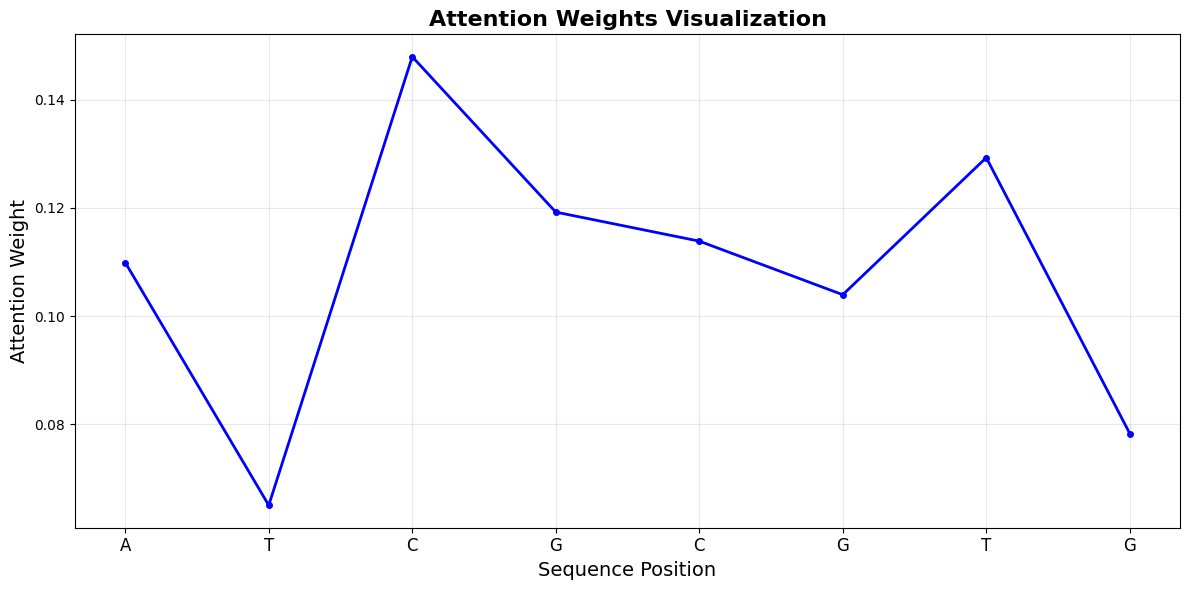

array([0.10990726, 0.06500999, 0.14795601, 0.11923233, 0.11386099,
       0.10395291, 0.12930304, 0.07828572], dtype=float32)

In [13]:
atten_vis.visualize(sequence)

In [19]:
# Additional utility methods for better attention visualization
class EnhancedAttentionVisualizer(AttentionVisualizer):
    """Enhanced version with additional visualization methods and error handling."""

    def get_tokenized_sequence(self, sequence):
        """Get tokenized sequence with special tokens for debugging."""
        tokenized = self.tokenizer(sequence, truncation=True, padding=True, max_length=32768, return_tensors="pt")
        input_ids = tokenized["input_ids"].squeeze(0)  # Remove batch dimension

        # Decode tokens to see what the model actually sees
        tokens = []
        for token_id in input_ids:
            token = self.tokenizer.decode([token_id])
            tokens.append(token)

        return tokens, input_ids

    def visualize_with_tokens(self, sequence):
        """Visualize attention weights showing actual tokens."""
        import matplotlib.pyplot as plt

        # Get tokenized representation
        tokens, input_ids = self.get_tokenized_sequence(sequence)

        # Get attention weights
        weights = self.attention_weights(sequence)[1]

        # Convert to numpy if tensor
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()

        # Remove CLS token (first token)
        tokens = tokens[:-1]
        weights = weights[:-1]

        # Create visualization
        plt.figure(figsize=(max(len(tokens) * 0.8, 10), 6))
        x_pos = range(len(tokens))

        # Plot bars for better visibility
        bars = plt.bar(x_pos, weights, alpha=0.7, color="steelblue", edgecolor="navy", linewidth=1)

        # Add value labels on bars
        for i, (bar, weight) in enumerate(zip(bars, weights)):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.001,
                f"{weight:.3f}",
                ha="center",
                va="bottom",
                fontsize=10,
            )

        plt.xticks(x_pos, tokens, fontsize=12, rotation=45 if len(tokens) > 10 else 0)
        plt.xlabel("Tokens", fontsize=14)
        plt.ylabel("Attention Weight", fontsize=14)
        plt.title(f"Attention Weights for Sequence: {sequence}", fontsize=16, fontweight="bold")
        plt.grid(True, alpha=0.3, axis="y")
        plt.tight_layout()
        plt.show()

        return weights, tokens

    def compare_sequences(self, sequences, labels=None):
        """Compare attention patterns across multiple sequences."""
        import matplotlib.pyplot as plt

        if labels is None:
            labels = [f"Seq {i + 1}" for i in range(len(sequences))]

        fig, axes = plt.subplots(len(sequences), 1, figsize=(12, 4 * len(sequences)))
        if len(sequences) == 1:
            axes = [axes]

        for i, (seq, label) in enumerate(zip(sequences, labels)):
            try:
                weights = self.attention_weights(seq)[1]
                if torch.is_tensor(weights):
                    weights = weights.detach().numpy()

                weights = weights[1:]  # Remove CLS token

                axes[i].plot(range(len(seq)), weights, "o-", linewidth=2, markersize=6)
                axes[i].set_xticks(range(len(seq)))
                axes[i].set_xticklabels(list(seq), fontsize=10)
                axes[i].set_ylabel("Attention Weight", fontsize=12)
                axes[i].set_title(f"{label}: {seq}", fontsize=14, fontweight="bold")
                axes[i].grid(True, alpha=0.3)

            except Exception as e:
                axes[i].text(
                    0.5,
                    0.5,
                    f"Error: {str(e)}",
                    ha="center",
                    va="center",
                    transform=axes[i].transAxes,
                    fontsize=12,
                    color="red",
                )

        plt.xlabel("Sequence Position", fontsize=14)
        plt.tight_layout()
        plt.show()


# Test the enhanced visualizer
enhanced_vis = EnhancedAttentionVisualizer()

Testing enhanced attention visualization...

1. Testing original visualize method:
{'Biological': '0.973', 'Chimeric Artifact': '0.027'}


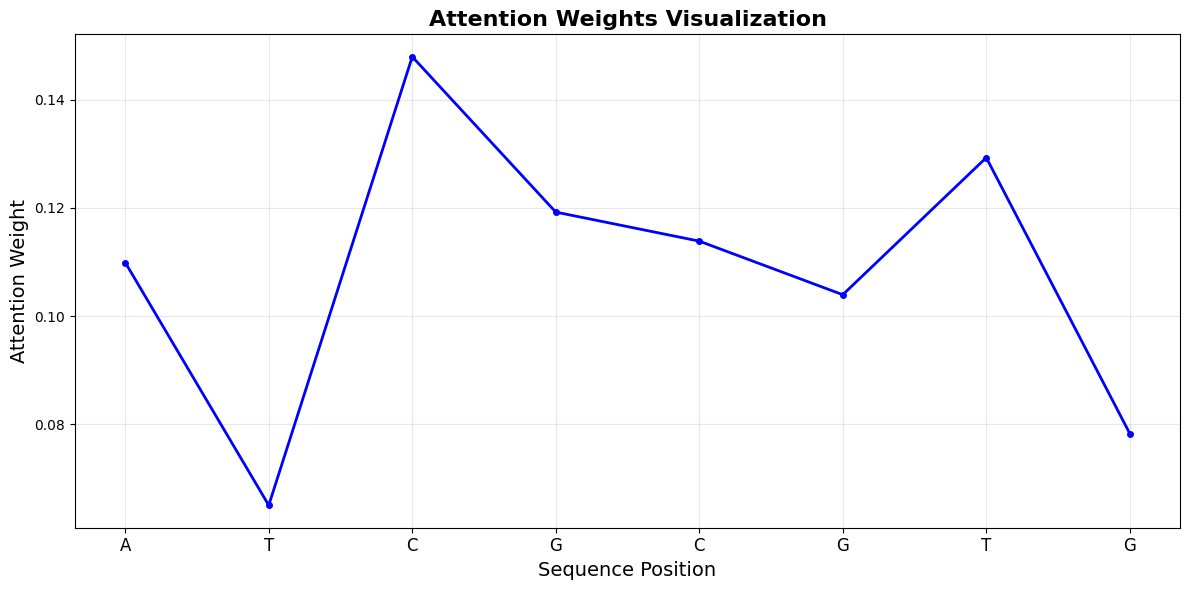

array([0.10990726, 0.06500999, 0.14795601, 0.11923233, 0.11386099,
       0.10395291, 0.12930304, 0.07828572], dtype=float32)


2. Testing visualize_with_tokens method:
{'Biological': '0.973', 'Chimeric Artifact': '0.027'}


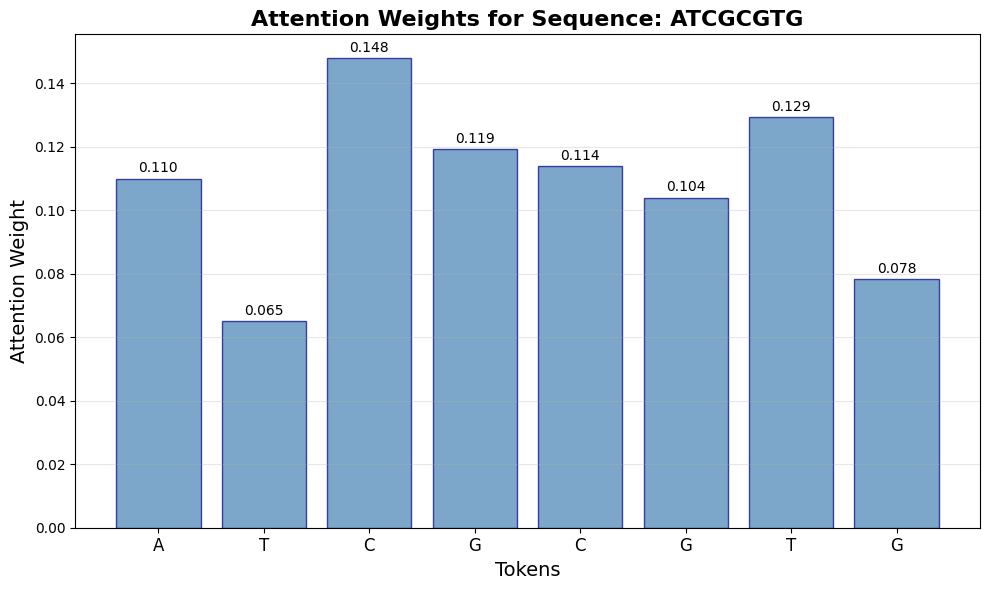

Tokens: ['A', 'T', 'C', 'G', 'C', 'G', 'T', 'G']
Weights: [0.10990726 0.06500999 0.14795601 0.11923233 0.11386099 0.10395291
 0.12930304 0.07828572]

3. Testing compare_sequences method:
{'Biological': '0.973', 'Chimeric Artifact': '0.027'}
{'Biological': '0.968', 'Chimeric Artifact': '0.032'}
{'Biological': '0.965', 'Chimeric Artifact': '0.035'}


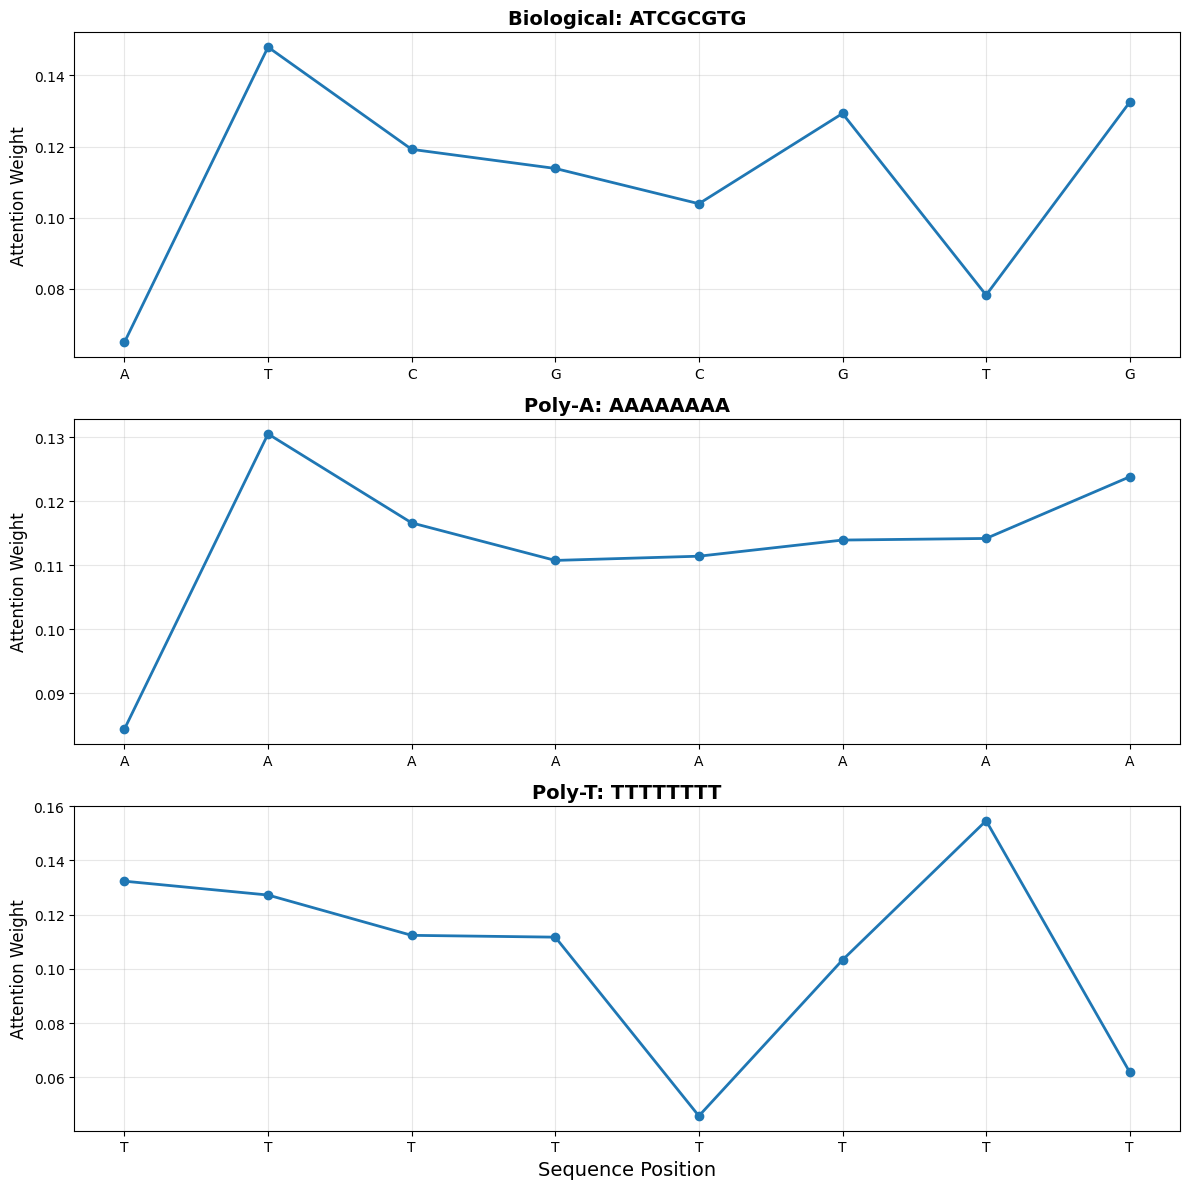

In [20]:
# Test the enhanced visualizer with better error handling
test_sequences = ["ATCGCGTG", "AAAAAAAA", "TTTTTTTT"]

print("Testing enhanced attention visualization...")
try:
    # Test the original method
    print("\n1. Testing original visualize method:")
    enhanced_vis.visualize(test_sequences[0])

    # Test the enhanced method with tokens
    print("\n2. Testing visualize_with_tokens method:")
    weights, tokens = enhanced_vis.visualize_with_tokens(test_sequences[0])
    print(f"Tokens: {tokens}")
    print(f"Weights: {weights}")

    # Test comparison method
    print("\n3. Testing compare_sequences method:")
    enhanced_vis.compare_sequences(test_sequences, ["Biological", "Poly-A", "Poly-T"])

except Exception as e:
    print(f"Error occurred: {e}")
    print("This might be due to attention weights not being available or model configuration issues.")

In [14]:
# Enhanced methods for handling LONG sequences (4k+ nucleotides)
class LongSequenceAttentionVisualizer(AttentionVisualizer):
    """Specialized visualizer for very long sequences (4k+ nucleotides)."""

    def visualize_long_sequence(self, sequence, max_display_length=200, window_size=50):
        """Visualize attention weights for very long sequences with windowing."""
        import matplotlib.pyplot as plt
        import numpy as np

        # Get attention weights
        weights = self.attention_weights(sequence)[1]

        # Convert to numpy if tensor
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()

        # Remove CLS token
        weights = weights[:-1]

        seq_length = len(sequence)
        weights_length = len(weights)

        print(f"Sequence length: {seq_length}, Attention weights length: {weights_length}")

        # Handle length mismatch
        min_length = min(seq_length, weights_length)
        sequence = sequence[:min_length]
        weights = weights[:min_length]

        if min_length <= max_display_length:
            # Short sequence - show everything
            self._plot_full_sequence(sequence, weights)
        else:
            # Long sequence - use windowing approach
            self._plot_windowed_sequence(sequence, weights, window_size)

        return weights

    def _plot_full_sequence(self, sequence, weights):
        """Plot full sequence for shorter sequences."""
        import matplotlib.pyplot as plt

        plt.figure(figsize=(15, 6))

        # Line plot
        plt.subplot(2, 1, 1)
        plt.plot(range(len(sequence)), weights, "b-", linewidth=1, alpha=0.7)
        plt.xlabel("Position")
        plt.ylabel("Attention Weight")
        plt.title(f"Attention Weights - Full Sequence (Length: {len(sequence)})")
        plt.grid(True, alpha=0.3)

        # Heatmap for better visualization
        plt.subplot(2, 1, 2)
        # Reshape weights for heatmap (create a 2D view)
        width = min(50, len(weights))
        height = (len(weights) + width - 1) // width
        weights_2d = np.pad(weights, (0, width * height - len(weights)), "constant")
        weights_2d = weights_2d.reshape(height, width)

        plt.imshow(weights_2d, aspect="auto", cmap="viridis", interpolation="nearest")
        plt.colorbar(label="Attention Weight")
        plt.xlabel("Position (mod 50)")
        plt.ylabel("Position // 50")
        plt.title("Attention Weights Heatmap")

        plt.tight_layout()
        plt.show()

    def _plot_windowed_sequence(self, sequence, weights, window_size=50):
        """Plot long sequence using windowing approach."""
        import matplotlib.pyplot as plt

        seq_length = len(sequence)
        num_windows = (seq_length + window_size - 1) // window_size

        # Create subplots for different windows
        fig, axes = plt.subplots(min(num_windows, 4), 1, figsize=(15, 4 * min(num_windows, 4)))
        if num_windows == 1:
            axes = [axes]

        for i in range(min(num_windows, 4)):
            start_idx = i * window_size
            end_idx = min((i + 1) * window_size, seq_length)

            window_seq = sequence[start_idx:end_idx]
            window_weights = weights[start_idx:end_idx]

            axes[i].plot(range(len(window_seq)), window_weights, "b-", linewidth=1, marker="o", markersize=2)
            axes[i].set_xlabel("Position within window")
            axes[i].set_ylabel("Attention Weight")
            axes[i].set_title(f"Window {i + 1}: Positions {start_idx}-{end_idx - 1}")
            axes[i].grid(True, alpha=0.3)

            # Add sequence labels for short windows
            if len(window_seq) <= 20:
                axes[i].set_xticks(range(len(window_seq)))
                axes[i].set_xticklabels(list(window_seq), fontsize=8, rotation=45)

        plt.tight_layout()
        plt.show()

        # Summary statistics
        print(f"\nAttention Weight Statistics for {seq_length}-length sequence:")
        print(f"Mean: {np.mean(weights):.4f}")
        print(f"Std: {np.std(weights):.4f}")
        print(f"Min: {np.min(weights):.4f}")
        print(f"Max: {np.max(weights):.4f}")
        print(f"Top 10 highest attention positions: {np.argsort(weights)[-10:]}")

    def find_attention_peaks(self, sequence, top_k=10):
        """Find positions with highest attention weights."""
        weights = self.attention_weights(sequence)[1]

        if torch.is_tensor(weights):
            weights = weights.detach().numpy()

        weights = weights[:-1]  # Remove CLS token

        # Find top-k attention positions
        top_indices = np.argsort(weights)[-top_k:][::-1]

        print(f"Top {top_k} attention positions:")
        for i, idx in enumerate(top_indices):
            if idx < len(sequence):
                print(f"{i + 1:2d}. Position {idx:4d}: '{sequence[idx]}' (weight: {weights[idx]:.4f})")

        return top_indices, weights[top_indices]

    def analyze_attention_patterns(self, sequence, pattern_length=10):
        """Analyze attention patterns in the sequence."""
        weights = self.attention_weights(sequence)[1]

        if torch.is_tensor(weights):
            weights = weights.detach().numpy()

        weights = weights[:-1]  # Remove CLS token

        # Find regions with high attention
        threshold = np.percentile(weights, 90)  # Top 10%
        high_attention_regions = []

        in_region = False
        region_start = 0

        for i, weight in enumerate(weights):
            if weight > threshold and not in_region:
                region_start = i
                in_region = True
            elif weight <= threshold and in_region:
                high_attention_regions.append((region_start, i - 1))
                in_region = False

        if in_region:
            high_attention_regions.append((region_start, len(weights) - 1))

        print(f"High attention regions (top 10% threshold: {threshold:.4f}):")
        for start, end in high_attention_regions:
            region_seq = sequence[start : end + 1]
            avg_weight = np.mean(weights[start : end + 1])
            print(f"  Position {start}-{end}: '{region_seq}' (avg weight: {avg_weight:.4f})")

        return high_attention_regions


# Create instance for testing
long_seq_vis = LongSequenceAttentionVisualizer()

Testing attention visualization with sequences of different lengths:
Short sequence (8 nt): ATCGCGTG
Medium sequence (200 nt): GTCCATTAAGAACGAGAATCCCCTCGGAAAGCCCGGGAGGCAATTGGCTA...
Long sequence (1000 nt): CATGATCACTGCGGATTCCGTAATGTGCACGAGTCAATCCAAATCGAGGC...
Very long sequence (4000 nt): ATGTGGCGTCAAGCTGGATTCTGCGGAAAGCTTTTCTGCGAGACCGGCTT...

TESTING LONG SEQUENCE VISUALIZER

1. Testing medium sequence (200 nt):
{'Biological': '0.987', 'Chimeric Artifact': '0.013'}
Sequence length: 200, Attention weights length: 200


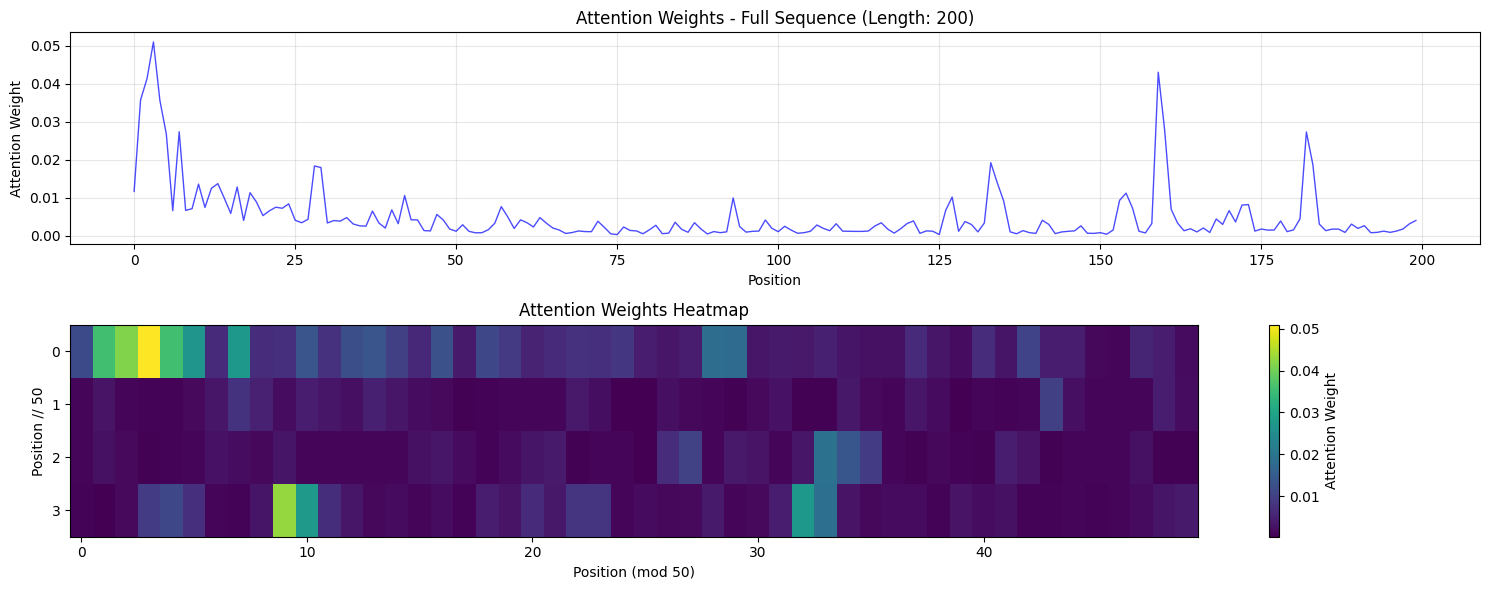

array([0.01162708, 0.03570115, 0.04127402, 0.0509468 , 0.03557127,
       0.02671886, 0.00657209, 0.02732415, 0.00664304, 0.00708604,
       0.01355568, 0.00741781, 0.012454  , 0.01367359, 0.00985211,
       0.00585003, 0.01278454, 0.00398076, 0.01128478, 0.00882785,
       0.00526474, 0.00651852, 0.00748241, 0.00719391, 0.00836124,
       0.00405091, 0.00339663, 0.00428973, 0.01831666, 0.01791797,
       0.00332694, 0.00396375, 0.00381924, 0.00474291, 0.00307383,
       0.00258462, 0.00249273, 0.00645963, 0.00332008, 0.0019925 ,
       0.00678078, 0.00313763, 0.01055189, 0.00415947, 0.00413718,
       0.0013229 , 0.00123632, 0.00557806, 0.00411175, 0.00172206,
       0.00115204, 0.00285727, 0.00111775, 0.00073944, 0.00076767,
       0.00156899, 0.00326883, 0.00762387, 0.00495211, 0.00188302,
       0.00415423, 0.00338918, 0.00227061, 0.00474391, 0.003284  ,
       0.00201576, 0.00147384, 0.00056684, 0.00081062, 0.00123117,
       0.00106202, 0.00103442, 0.00377254, 0.00219001, 0.00046


2. Finding attention peaks in medium sequence:
{'Biological': '0.987', 'Chimeric Artifact': '0.013'}
Top 5 attention positions:
 1. Position    3: 'C' (weight: 0.0509)
 2. Position  159: 'A' (weight: 0.0430)
 3. Position    2: 'C' (weight: 0.0413)
 4. Position    1: 'T' (weight: 0.0357)
 5. Position    4: 'A' (weight: 0.0356)

3. Analyzing attention patterns:
{'Biological': '0.987', 'Chimeric Artifact': '0.013'}
High attention regions (top 10% threshold: 0.0112):
  Position 0-5: 'GTCCAT' (avg weight: 0.0336)
  Position 7-7: 'A' (avg weight: 0.0273)
  Position 10-10: 'A' (avg weight: 0.0136)
  Position 12-13: 'CG' (avg weight: 0.0131)
  Position 16-16: 'A' (avg weight: 0.0128)
  Position 18-18: 'T' (avg weight: 0.0113)
  Position 28-29: 'AA' (avg weight: 0.0181)
  Position 133-134: 'AG' (avg weight: 0.0166)
  Position 159-160: 'AA' (avg weight: 0.0353)
  Position 182-183: 'AG' (avg weight: 0.0230)

4. Testing very long sequence (4000 nt) - this may take a moment:
{'Biological': '0.952'

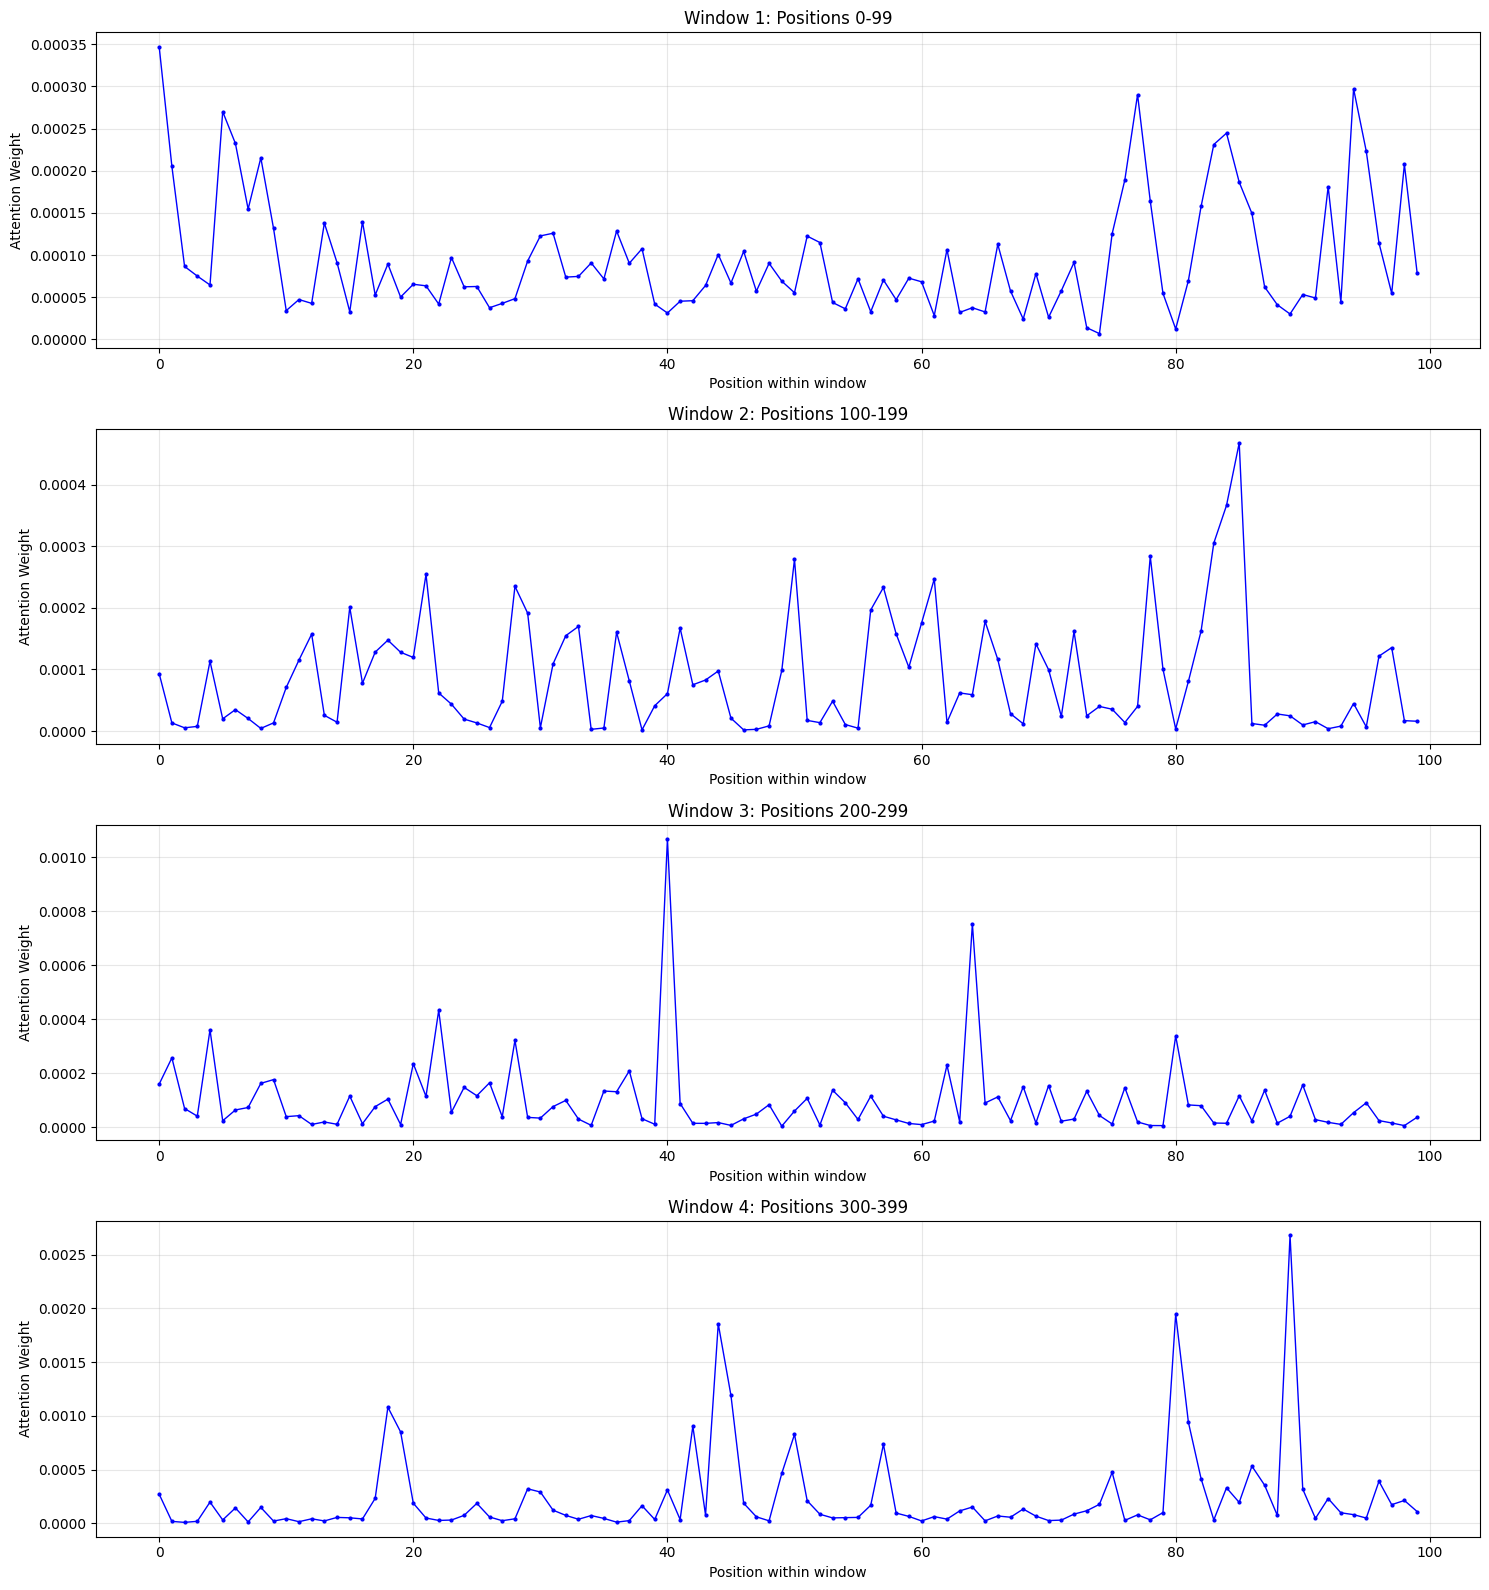


Attention Weight Statistics for 4000-length sequence:
Mean: 0.0002
Std: 0.0003
Min: 0.0000
Max: 0.0027
Top 10 highest attention positions: [3518 1681 3165 1529 1522 3274 2669 1573 1601  389]


array([3.4706283e-04, 2.0527119e-04, 8.6583961e-05, ..., 8.4260922e-05,
       9.0119920e-06, 1.2875983e-05], shape=(4000,), dtype=float32)


5. Finding attention peaks in very long sequence:
{'Biological': '0.952', 'Chimeric Artifact': '0.048'}
Top 10 attention positions:
 1. Position  389: 'G' (weight: 0.0027)
 2. Position 1601: 'T' (weight: 0.0026)
 3. Position 1573: 'G' (weight: 0.0026)
 4. Position 2669: 'C' (weight: 0.0025)
 5. Position 3274: 'T' (weight: 0.0025)
 6. Position 1522: 'C' (weight: 0.0024)
 7. Position 1529: 'A' (weight: 0.0023)
 8. Position 3165: 'G' (weight: 0.0023)
 9. Position 1681: 'C' (weight: 0.0023)
10. Position 3518: 'C' (weight: 0.0022)


In [22]:
# Test with a very long sequence (simulating 4k nucleotides)
import random


def generate_long_sequence(length=4000):
    """Generate a random DNA sequence of specified length."""
    nucleotides = ["A", "T", "C", "G"]
    return "".join(random.choices(nucleotides, k=length))


# Generate test sequences of different lengths
short_seq = "ATCGCGTG"  # Original test sequence
medium_seq = generate_long_sequence(200)  # Medium length
long_seq = generate_long_sequence(1000)  # Long sequence
very_long_seq = generate_long_sequence(4000)  # Very long sequence (4k)

print("Testing attention visualization with sequences of different lengths:")
print(f"Short sequence (8 nt): {short_seq}")
print(f"Medium sequence (200 nt): {medium_seq[:50]}...")
print(f"Long sequence (1000 nt): {long_seq[:50]}...")
print(f"Very long sequence (4000 nt): {very_long_seq[:50]}...")

# Test the long sequence visualizer
print("\n" + "=" * 60)
print("TESTING LONG SEQUENCE VISUALIZER")
print("=" * 60)

try:
    # Test with medium sequence first
    print("\n1. Testing medium sequence (200 nt):")
    long_seq_vis.visualize_long_sequence(medium_seq)

    # Test attention peaks
    print("\n2. Finding attention peaks in medium sequence:")
    peaks, peak_weights = long_seq_vis.find_attention_peaks(medium_seq, top_k=5)

    # Test pattern analysis
    print("\n3. Analyzing attention patterns:")
    regions = long_seq_vis.analyze_attention_patterns(medium_seq)

    # Test with very long sequence
    print("\n4. Testing very long sequence (4000 nt) - this may take a moment:")
    long_seq_vis.visualize_long_sequence(very_long_seq, window_size=100)

    print("\n5. Finding attention peaks in very long sequence:")
    peaks_long, peak_weights_long = long_seq_vis.find_attention_peaks(very_long_seq, top_k=10)

except Exception as e:
    print(f"Error occurred: {e}")
    print("This might be due to memory constraints or model limitations.")
    print("Try with shorter sequences first.")

In [15]:
# Focus on biologically meaningful positions


class BiologicalPositionAnalyzer(LongSequenceAttentionVisualizer):
    """Analyze attention patterns around specific biologically meaningful positions."""

    def analyze_position_of_interest(self, sequence, positions, window_size=50):
        """
        Analyze attention around specific biological positions.

        Args:
            sequence: DNA sequence
            positions: List of positions of interest (0-indexed)
            window_size: Size of window around each position to analyze
        """
        import matplotlib.pyplot as plt
        import numpy as np

        # Get attention weights
        weights = self.attention_weights(sequence)[1]
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()
        weights = weights[:-1]  # Remove CLS token

        seq_length = len(sequence)
        weights_length = len(weights)
        min_length = min(seq_length, weights_length)

        # Validate positions
        valid_positions = [pos for pos in positions if 0 <= pos < min_length]
        if len(valid_positions) != len(positions):
            print(f"Warning: Some positions are out of range. Valid positions: {valid_positions}")

        if not valid_positions:
            print("No valid positions to analyze!")
            return None

        # Calculate statistics
        overall_mean = np.mean(weights)
        overall_std = np.std(weights)

        print(f"Sequence length: {min_length}")
        print(f"Overall attention statistics:")
        print(f"  Mean: {overall_mean:.4f}")
        print(f"  Std: {overall_std:.4f}")
        print(f"  Min: {np.min(weights):.4f}")
        print(f"  Max: {np.max(weights):.4f}")

        # Analyze each position of interest
        position_stats = []
        for pos in valid_positions:
            # Define window around position
            start = max(0, pos - window_size // 2)
            end = min(min_length, pos + window_size // 2)

            window_weights = weights[start:end]
            window_mean = np.mean(window_weights)
            window_std = np.std(window_weights)

            # Calculate z-score (how many standard deviations from mean)
            z_score = (window_mean - overall_mean) / overall_std if overall_std > 0 else 0

            position_stats.append(
                {
                    "position": pos,
                    "nucleotide": sequence[pos],
                    "window_start": start,
                    "window_end": end,
                    "window_mean": window_mean,
                    "window_std": window_std,
                    "z_score": z_score,
                    "relative_to_mean": window_mean / overall_mean if overall_mean > 0 else 0,
                }
            )

            print(f"\nPosition {pos} ('{sequence[pos]}'):")
            print(f"  Window [{start}:{end}]: {window_mean:.4f} ± {window_std:.4f}")
            print(f"  Z-score: {z_score:.2f} (higher than {((1 + np.sign(z_score)) / 2 * 100):.1f}% of sequence)")
            print(f"  Relative to mean: {position_stats[-1]['relative_to_mean']:.2f}x")

        return position_stats

    def visualize_position_comparison(self, sequence, positions, window_size=50, context_size=200):
        """Visualize attention around specific positions with context."""
        import matplotlib.pyplot as plt
        import numpy as np

        # Get attention weights
        weights = self.attention_weights(sequence)[1]
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()
        weights = weights[:-1]  # Remove CLS token

        seq_length = len(sequence)
        weights_length = len(weights)
        min_length = min(seq_length, weights_length)

        # Validate positions
        valid_positions = [pos for pos in positions if 0 <= pos < min_length]

        if not valid_positions:
            print("No valid positions to visualize!")
            return

        # Create visualization
        fig, axes = plt.subplots(len(valid_positions) + 1, 1, figsize=(15, 4 * (len(valid_positions) + 1)))
        if len(valid_positions) == 0:
            axes = [axes]

        # Overall sequence view
        axes[0].plot(range(min_length), weights, "b-", linewidth=0.5, alpha=0.7)
        axes[0].axhline(y=np.mean(weights), color="r", linestyle="--", alpha=0.7, label="Overall Mean")

        # Mark positions of interest
        for i, pos in enumerate(valid_positions):
            axes[0].axvline(x=pos, color="red", linestyle="-", linewidth=2, alpha=0.8)
            axes[0].text(
                pos,
                np.max(weights) * 0.9,
                f"P{i + 1}",
                ha="center",
                va="bottom",
                fontsize=10,
                fontweight="bold",
                color="red",
            )

        axes[0].set_title(f"Full Sequence Attention Pattern (Length: {min_length})", fontsize=14, fontweight="bold")
        axes[0].set_ylabel("Attention Weight")
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Detailed views for each position
        for i, pos in enumerate(valid_positions):
            # Define context window
            start = max(0, pos - context_size // 2)
            end = min(min_length, pos + context_size // 2)

            window_weights = weights[start:end]
            window_positions = range(start, end)

            axes[i + 1].plot(window_positions, window_weights, "b-", linewidth=1, marker="o", markersize=2)
            axes[i + 1].axvline(x=pos, color="red", linestyle="-", linewidth=3, alpha=0.8, label=f"Position {pos}")
            axes[i + 1].axhline(y=np.mean(weights), color="r", linestyle="--", alpha=0.7, label="Overall Mean")
            axes[i + 1].axhline(y=np.mean(window_weights), color="orange", linestyle=":", alpha=0.7, label="Local Mean")

            # Highlight the analysis window
            analysis_start = max(start, pos - window_size // 2)
            analysis_end = min(end, pos + window_size // 2)
            axes[i + 1].axvspan(analysis_start, analysis_end, alpha=0.2, color="yellow", label="Analysis Window")

            axes[i + 1].set_title(
                f'Position {pos} ("{sequence[pos]}") - Context Window', fontsize=12, fontweight="bold"
            )
            axes[i + 1].set_xlabel("Sequence Position")
            axes[i + 1].set_ylabel("Attention Weight")
            axes[i + 1].legend()
            axes[i + 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def compare_biological_regions(self, sequence, region_definitions):
        """
        Compare attention between different biological regions.

        Args:
            sequence: DNA sequence
            region_definitions: Dict with region names and (start, end) tuples
                e.g., {'promoter': (100, 200), 'coding': (500, 1500), 'terminator': (1800, 2000)}
        """
        import matplotlib.pyplot as plt
        import numpy as np

        # Get attention weights
        weights = self.attention_weights(sequence)[1]
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()
        weights = weights[:-1]  # Remove CLS token

        seq_length = len(sequence)
        weights_length = len(weights)
        min_length = min(seq_length, weights_length)

        # Analyze each region
        region_stats = {}
        for region_name, (start, end) in region_definitions.items():
            # Validate and clip region boundaries
            start = max(0, min(start, min_length))
            end = max(start, min(end, min_length))

            if start >= end:
                print(f"Warning: Invalid region {region_name} [{start}, {end}]")
                continue

            region_weights = weights[start:end]
            region_stats[region_name] = {
                "start": start,
                "end": end,
                "length": end - start,
                "mean": np.mean(region_weights),
                "std": np.std(region_weights),
                "median": np.median(region_weights),
                "max": np.max(region_weights),
                "min": np.min(region_weights),
                "weights": region_weights,
            }

        # Print comparison
        print("Biological Region Attention Comparison:")
        print("=" * 60)

        overall_mean = np.mean(weights)
        overall_std = np.std(weights)

        for region_name, stats in region_stats.items():
            z_score = (stats["mean"] - overall_mean) / overall_std if overall_std > 0 else 0
            relative = stats["mean"] / overall_mean if overall_mean > 0 else 0

            print(f"\n{region_name.upper()} [{stats['start']}-{stats['end']}] (length: {stats['length']}):")
            print(f"  Mean attention: {stats['mean']:.4f} (z-score: {z_score:.2f})")
            print(f"  Relative to overall: {relative:.2f}x")
            print(f"  Range: [{stats['min']:.4f}, {stats['max']:.4f}]")
            print(f"  Std: {stats['std']:.4f}")

        # Visualization
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

        # Full sequence with regions highlighted
        ax1.plot(range(min_length), weights, "b-", linewidth=0.5, alpha=0.7)
        ax1.axhline(y=overall_mean, color="r", linestyle="--", alpha=0.7, label="Overall Mean")

        colors = ["red", "green", "blue", "orange", "purple", "brown"]
        for i, (region_name, stats) in enumerate(region_stats.items()):
            color = colors[i % len(colors)]
            ax1.axvspan(stats["start"], stats["end"], alpha=0.3, color=color, label=region_name)
            ax1.text(
                (stats["start"] + stats["end"]) / 2,
                np.max(weights) * 0.9,
                region_name,
                ha="center",
                va="bottom",
                fontweight="bold",
                color=color,
            )

        ax1.set_title("Sequence with Biological Regions Highlighted", fontsize=14, fontweight="bold")
        ax1.set_ylabel("Attention Weight")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Box plot comparison
        region_data = [stats["weights"] for stats in region_stats.values()]
        region_names = list(region_stats.keys())

        bp = ax2.boxplot(region_data, labels=region_names, patch_artist=True)
        ax2.axhline(y=overall_mean, color="r", linestyle="--", alpha=0.7, label="Overall Mean")

        # Color the boxes
        for patch, color in zip(bp["boxes"], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax2.set_title("Attention Distribution by Biological Region", fontsize=14, fontweight="bold")
        ax2.set_ylabel("Attention Weight")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return region_stats


# Create instance for biological analysis
bio_analyzer = BiologicalPositionAnalyzer()

BIOLOGICAL POSITION ATTENTION ANALYSIS
Test sequence length: 2000
Analyzing positions: [1200, 500, 1500, 1800]
Sequence preview: TTACAAGGGAGACTTCACTGCAGCCGTTACCATAATGATTCCTGTACGAGATCTTTCCTACGGGCTAGTGCCGTGCCTTCGCCAAGTATATGATCAACGG...

1. POSITION ANALYSIS
{'Biological': '0.845', 'Chimeric Artifact': '0.155'}
Sequence length: 2000
Overall attention statistics:
  Mean: 0.0005
  Std: 0.0012
  Min: 0.0000
  Max: 0.0149

Position 1200 ('C'):
  Window [1150:1250]: 0.0001 ± 0.0001
  Z-score: -0.31 (higher than 0.0% of sequence)
  Relative to mean: 0.28x

Position 500 ('C'):
  Window [450:550]: 0.0001 ± 0.0002
  Z-score: -0.30 (higher than 0.0% of sequence)
  Relative to mean: 0.29x

Position 1500 ('C'):
  Window [1450:1550]: 0.0005 ± 0.0004
  Z-score: -0.02 (higher than 0.0% of sequence)
  Relative to mean: 0.95x

Position 1800 ('T'):
  Window [1750:1850]: 0.0013 ± 0.0019
  Z-score: 0.71 (higher than 100.0% of sequence)
  Relative to mean: 2.68x

2. POSITION VISUALIZATION
{'Biological': '0.845

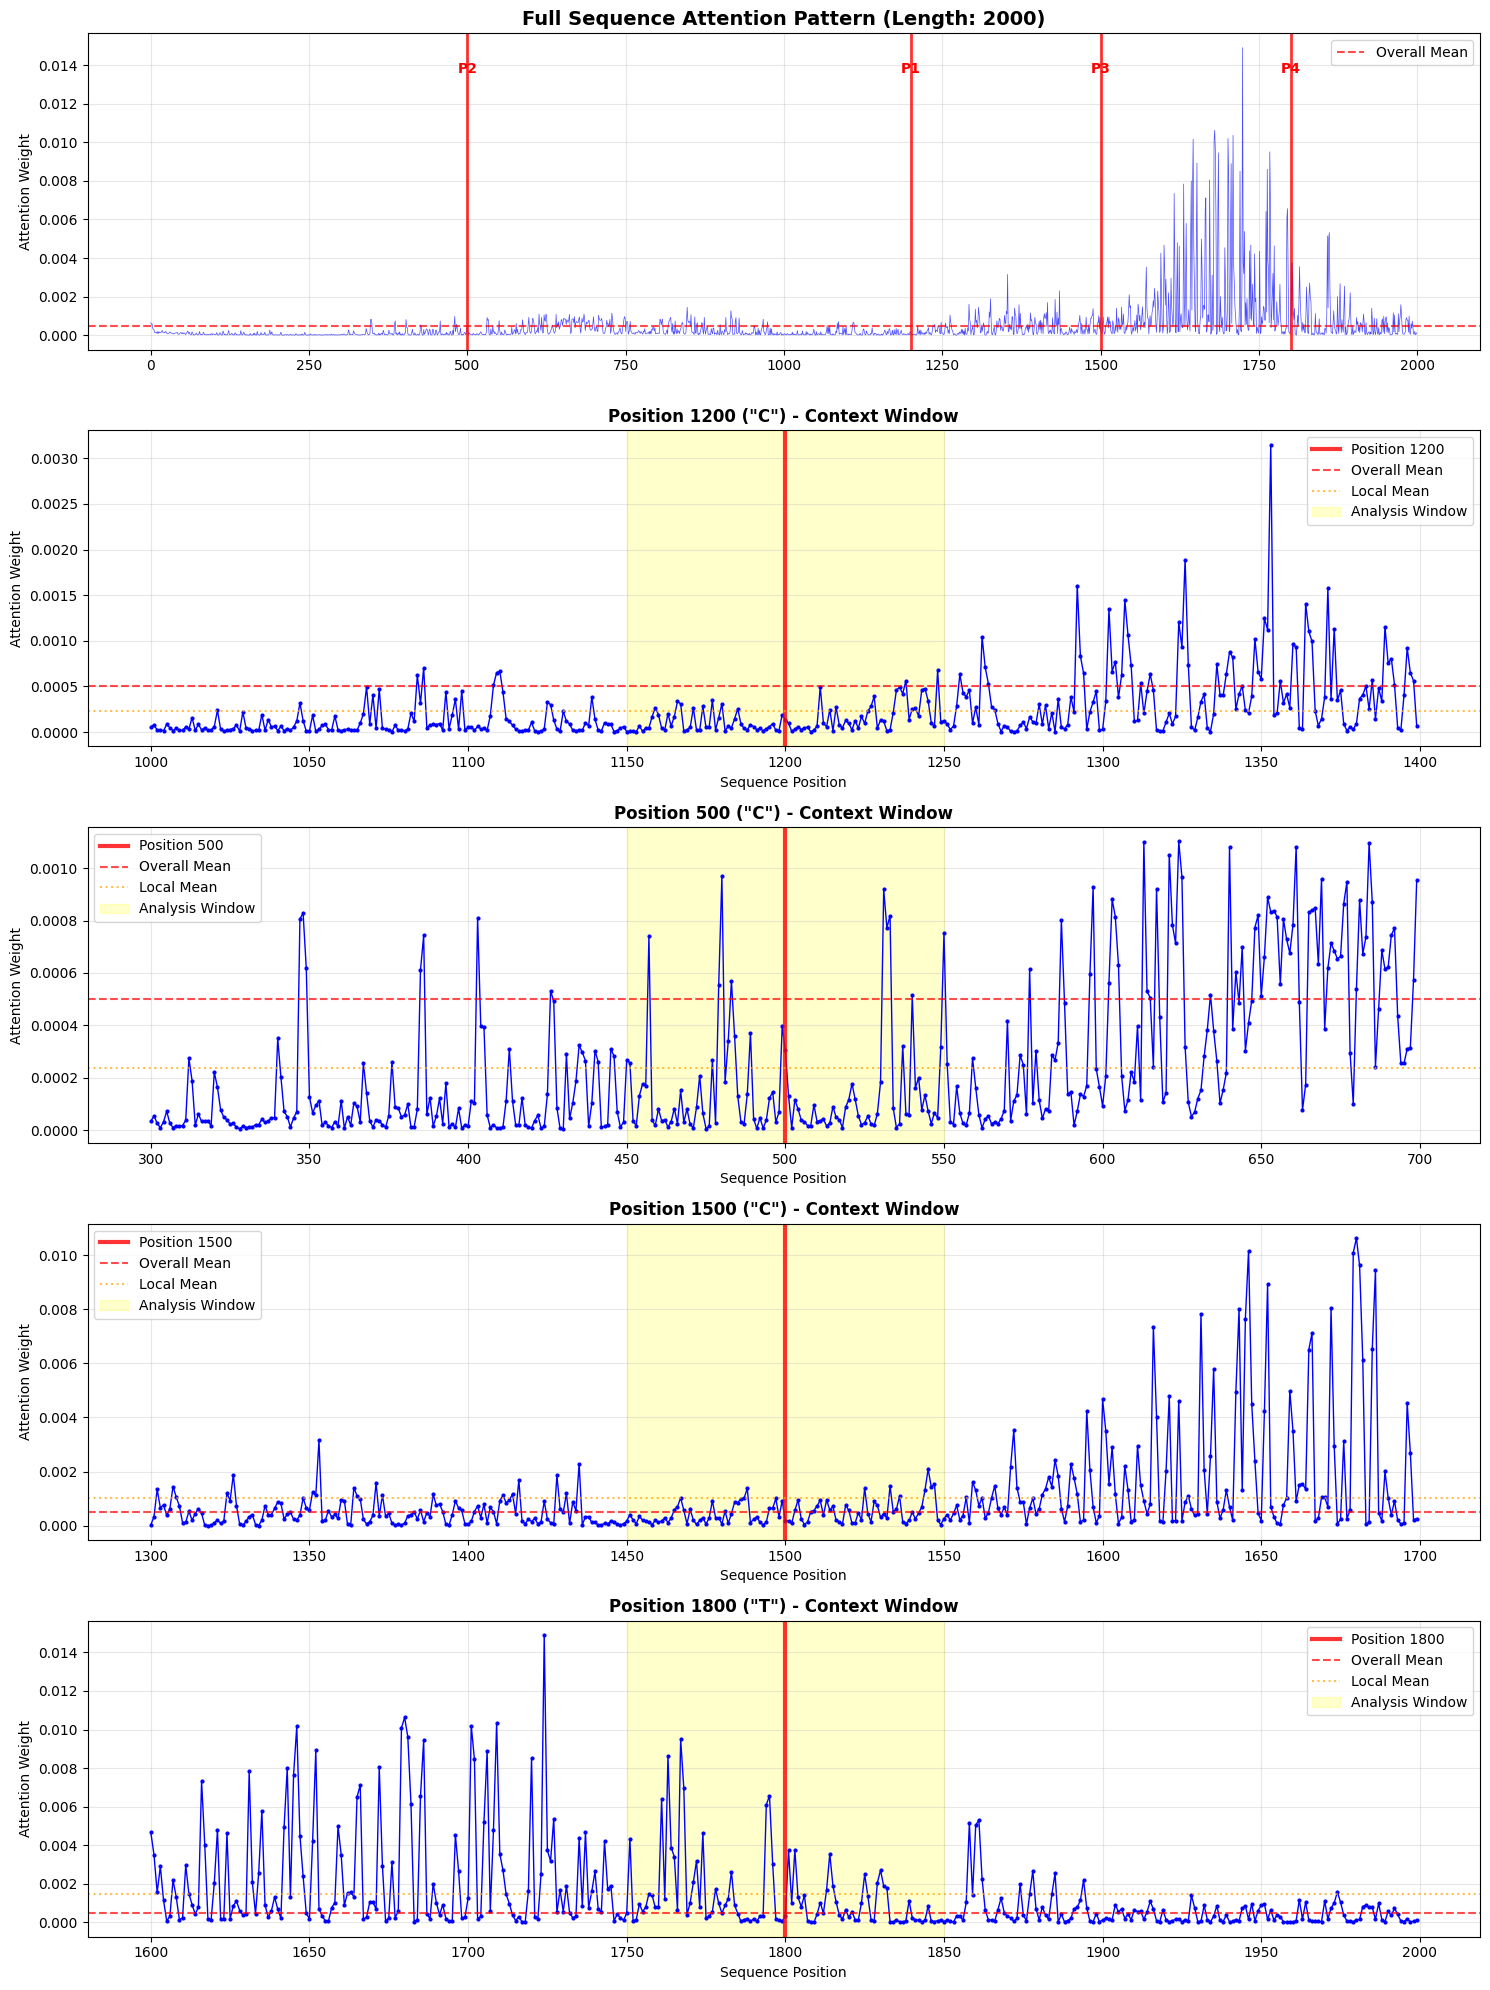


3. BIOLOGICAL REGION COMPARISON
{'Biological': '0.845', 'Chimeric Artifact': '0.155'}
Biological Region Attention Comparison:

UPSTREAM [0-400] (length: 400):
  Mean attention: 0.0001 (z-score: -0.36)
  Relative to overall: 0.14x
  Range: [0.0000, 0.0008]
  Std: 0.0001

PROMOTER [400-600] (length: 200):
  Mean attention: 0.0002 (z-score: -0.29)
  Relative to overall: 0.31x
  Range: [0.0000, 0.0010]
  Std: 0.0002

CODING_START [600-800] (length: 200):
  Mean attention: 0.0004 (z-score: -0.06)
  Relative to overall: 0.86x
  Range: [0.0000, 0.0011]
  Std: 0.0003

MIDDLE_CODING [800-1200] (length: 400):
  Mean attention: 0.0002 (z-score: -0.27)
  Relative to overall: 0.36x
  Range: [0.0000, 0.0014]
  Std: 0.0002

POSITION_OF_INTEREST [1150-1250] (length: 100):
  Mean attention: 0.0001 (z-score: -0.31)
  Relative to overall: 0.28x
  Range: [0.0000, 0.0007]
  Std: 0.0001

END_CODING [1200-1400] (length: 200):
  Mean attention: 0.0004 (z-score: -0.11)
  Relative to overall: 0.73x
  Range: [0

/var/folders/s3/vs6nrrg52sdfjk3z90p7ndt94gg4tq/T/ipykernel_77481/3934692259.py:256: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(region_data, labels=region_names, patch_artist=True)


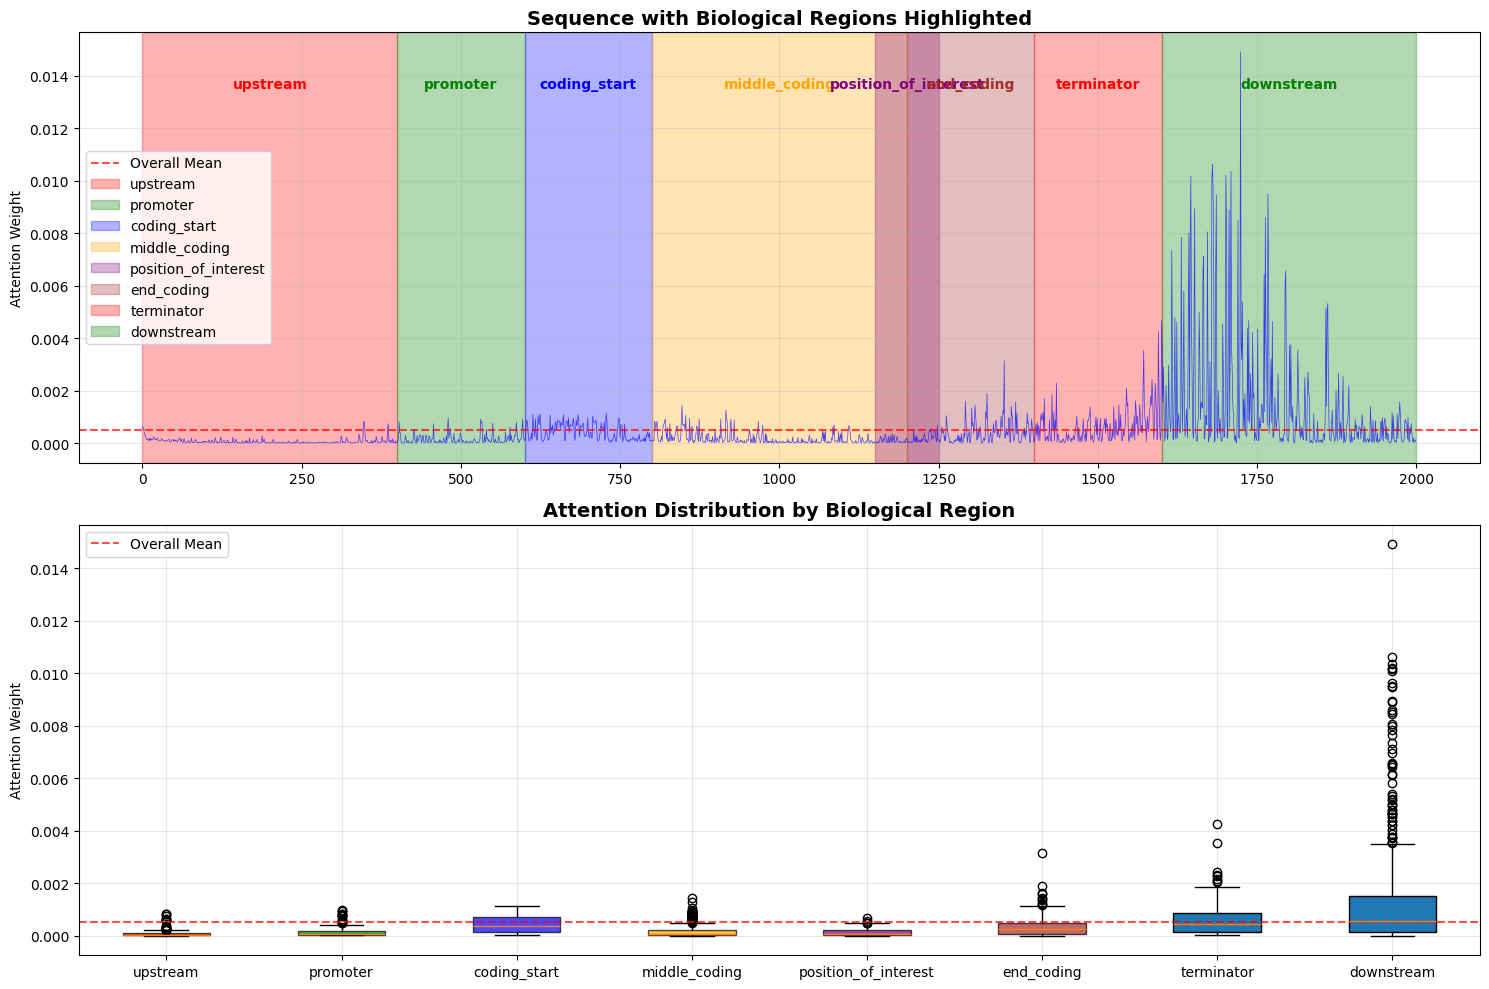


4. SUMMARY OF FINDINGS
Position Analysis Summary:
  Position 1200 (C):
    - Attention level: 0.28x the sequence average
    - Z-score: -0.31 (above 0.0% of sequence)
    - ⬇️  LOWER attention than average
  Position 500 (C):
    - Attention level: 0.29x the sequence average
    - Z-score: -0.30 (above 0.0% of sequence)
    - ⬇️  LOWER attention than average
  Position 1500 (C):
    - Attention level: 0.95x the sequence average
    - Z-score: -0.02 (above 0.0% of sequence)
    - ➡️  SIMILAR attention to average
  Position 1800 (T):
    - Attention level: 2.68x the sequence average
    - Z-score: 0.71 (above 100.0% of sequence)
    - ⬆️  HIGHER attention than average

5. TOP ATTENTION POSITIONS FOR COMPARISON
{'Biological': '0.845', 'Chimeric Artifact': '0.155'}
Top 10 attention positions:
 1. Position 1724: 'G' (weight: 0.0149)
 2. Position 1680: 'A' (weight: 0.0106)
 3. Position 1709: 'C' (weight: 0.0104)
 4. Position 1701: 'T' (weight: 0.0102)
 5. Position 1646: 'G' (weight: 0.0102)

In [24]:
# Test biological position analysis
print("=" * 80)
print("BIOLOGICAL POSITION ATTENTION ANALYSIS")
print("=" * 80)

# Generate a longer test sequence (2000 nucleotides)
test_sequence = generate_long_sequence(2000)

# Define some biologically meaningful positions (e.g., start codon, regulatory sites, etc.)
biological_positions = [
    1200,  # Position of interest as mentioned in the question
    500,  # Another interesting position
    1500,  # Third position
    1800,  # Fourth position
]

print(f"Test sequence length: {len(test_sequence)}")
print(f"Analyzing positions: {biological_positions}")
print(f"Sequence preview: {test_sequence[:100]}...")

try:
    # 1. Analyze specific positions of interest
    print("\n" + "=" * 60)
    print("1. POSITION ANALYSIS")
    print("=" * 60)

    position_stats = bio_analyzer.analyze_position_of_interest(
        test_sequence,
        biological_positions,
        window_size=100,  # Analyze ±50 nucleotides around each position
    )

    # 2. Visualize position comparison
    print("\n" + "=" * 60)
    print("2. POSITION VISUALIZATION")
    print("=" * 60)

    bio_analyzer.visualize_position_comparison(
        test_sequence,
        biological_positions,
        window_size=100,  # Analysis window
        context_size=400,  # Visualization context
    )

    # 3. Compare biological regions
    print("\n" + "=" * 60)
    print("3. BIOLOGICAL REGION COMPARISON")
    print("=" * 60)

    # Define different biological regions
    region_definitions = {
        "upstream": (0, 400),
        "promoter": (400, 600),
        "coding_start": (600, 800),
        "middle_coding": (800, 1200),
        "position_of_interest": (1150, 1250),  # Around position 1200
        "end_coding": (1200, 1400),
        "terminator": (1400, 1600),
        "downstream": (1600, 2000),
    }

    region_stats = bio_analyzer.compare_biological_regions(test_sequence, region_definitions)

    # 4. Summary of findings
    print("\n" + "=" * 60)
    print("4. SUMMARY OF FINDINGS")
    print("=" * 60)

    if position_stats:
        print("Position Analysis Summary:")
        for i, stats in enumerate(position_stats):
            print(f"  Position {stats['position']} ({stats['nucleotide']}):")
            print(f"    - Attention level: {stats['relative_to_mean']:.2f}x the sequence average")
            print(
                f"    - Z-score: {stats['z_score']:.2f} (above {((1 + np.sign(stats['z_score'])) / 2 * 100):.1f}% of sequence)"
            )
            if stats["relative_to_mean"] > 1.2:
                print(f"    - ⬆️  HIGHER attention than average")
            elif stats["relative_to_mean"] < 0.8:
                print(f"    - ⬇️  LOWER attention than average")
            else:
                print(f"    - ➡️  SIMILAR attention to average")

    # 5. Find highest attention positions for comparison
    print("\n" + "=" * 60)
    print("5. TOP ATTENTION POSITIONS FOR COMPARISON")
    print("=" * 60)

    peaks, peak_weights = bio_analyzer.find_attention_peaks(test_sequence, top_k=10)

    # Check if any of our biological positions are in the top attention positions
    biological_peaks = [pos for pos in biological_positions if pos in peaks[:10]]
    if biological_peaks:
        print(f"🎯 Biological positions in top 10 attention: {biological_peaks}")
    else:
        print("ℹ️  None of the biological positions are in the top 10 attention positions")
        print("   This suggests they may have average or lower attention levels.")

except Exception as e:
    print(f"Error occurred: {e}")
    print("This might be due to model limitations or memory constraints.")
    print("Try with shorter sequences first.")

# Analysis

In [16]:
from pathlib import Path


def chimeric_read_iterator(bam_path: Path):
    import pysam

    bam = pysam.AlignmentFile(bam_path)

    for read in bam.fetch():
        if chimeralm.data.bam.is_chimeric(read):
            yield read

In [39]:
bam_file = Path("/gpfs/projects/b1171/ylk4626/project/Chimera/data/raw/PC3_10_cells_MDA_Mk1c_dirty.bam")

In [40]:
chimeric_reads = chimeric_read_iterator(bam_file)

In [41]:
def create_chimeric_reads_dict(path):
    return {r.query_name: r for r in chimeric_read_iterator(bam_file)}

In [42]:
chimeric_reads_dict = create_chimeric_reads_dict(bam_file)

[E::hts_open_format] Failed to open file "/gpfs/projects/b1171/ylk4626/project/Chimera/data/raw/PC3_10_cells_MDA_Mk1c_dirty.bam" : No such file or directory


FileNotFoundError: [Errno 2] Could not open alignment file: No such file or directory: '/gpfs/projects/b1171/ylk4626/project/Chimera/data/raw/PC3_10_cells_MDA_Mk1c_dirty.bam'

In [8]:
len(list(chimeric_reads))

1666427

In [76]:
r1 = next(chimeric_reads)
r1.query_name
r1.get_tag("SA")

'ce692a8c-b768-42aa-a0d9-dca0b71c19b3'

'chr17,54129515,-,39S470M7I849S,1,46;chr12,31020091,+,675S176M514S,9,18;'

In [14]:
r1.query_alignment_start
r1.query_alignment_end

272

739

In [15]:
r1.query_alignment_end - r1.query_alignment_start

467

In [16]:
r1.query_length

739

In [17]:
len(r1.query_sequence)

739

In [18]:
r1.reference_start
r1.reference_end
r1.reference_end - r1.reference_start

11704

12169

465

In [19]:
def get_sequence_and_pos(read):
    return read.query_name, read.query_sequence, [read.query_alignment_start, read.query_alignment_end - 1]

In [42]:
read_name, test_sequence, biological_positions = get_sequence_and_pos(r1)

In [26]:
def show_attention_with_biological_pos(read):
    read_name, test_sequence, biological_positions = get_sequence_and_pos(read)

    print(f"{read_name}")

    position_stats = bio_analyzer.analyze_position_of_interest(
        test_sequence,
        biological_positions,
        window_size=100,  # Analyze ±50 nucleotides around each position
    )

    # 2. Visualize position comparison
    print("\n" + "=" * 60)
    print("2. POSITION VISUALIZATION")
    print("=" * 60)

    bio_analyzer.visualize_position_comparison(
        test_sequence,
        biological_positions,
        window_size=100,  # Analysis window
        context_size=400,  # Visualization context
    )

    # 4. Summary of findings
    print("\n" + "=" * 60)
    print("4. SUMMARY OF FINDINGS")
    print("=" * 60)

    if position_stats:
        print("Position Analysis Summary:")
        for i, stats in enumerate(position_stats):
            print(f"  Position {stats['position']} ({stats['nucleotide']}):")
            print(f"    - Attention level: {stats['relative_to_mean']:.2f}x the sequence average")
            print(
                f"    - Z-score: {stats['z_score']:.2f} (above {((1 + np.sign(stats['z_score'])) / 2 * 100):.1f}% of sequence)"
            )
            if stats["relative_to_mean"] > 1.2:
                print(f"    - ⬆️  HIGHER attention than average")
            elif stats["relative_to_mean"] < 0.8:
                print(f"    - ⬇️  LOWER attention than average")
            else:
                print(f"    - ➡️  SIMILAR attention to average")

    # 5. Find highest attention positions for comparison
    print("\n" + "=" * 60)
    print("5. TOP ATTENTION POSITIONS FOR COMPARISON")
    print("=" * 60)

    peaks, peak_weights = bio_analyzer.find_attention_peaks(test_sequence, top_k=10)

    # Check if any of our biological positions are in the top attention positions
    biological_peaks = [pos for pos in biological_positions if pos in peaks[:10]]
    if biological_peaks:
        print(f"🎯 Biological positions in top 10 attention: {biological_peaks}")
    else:
        print("ℹ️  None of the biological positions are in the top 10 attention positions")
        print("   This suggests they may have average or lower attention levels.")

In [58]:
selected_reads = [
    "d76d0405-d65d-402a-946e-df797a0ada8a",
]

ce692a8c-b768-42aa-a0d9-dca0b71c19b3
{'Biological': '0.372', 'Chimeric Artifact': '0.628'}
Sequence length: 1365
Overall attention statistics:
  Mean: 0.0007
  Std: 0.0003
  Min: 0.0000
  Max: 0.0036

Position 800 ('G'):
  Window [750:850]: 0.0006 ± 0.0004
  Z-score: -0.27 (higher than 0.0% of sequence)
  Relative to mean: 0.87x

Position 1325 ('T'):
  Window [1275:1365]: 0.0007 ± 0.0002
  Z-score: -0.03 (higher than 0.0% of sequence)
  Relative to mean: 0.99x

2. POSITION VISUALIZATION
{'Biological': '0.372', 'Chimeric Artifact': '0.628'}


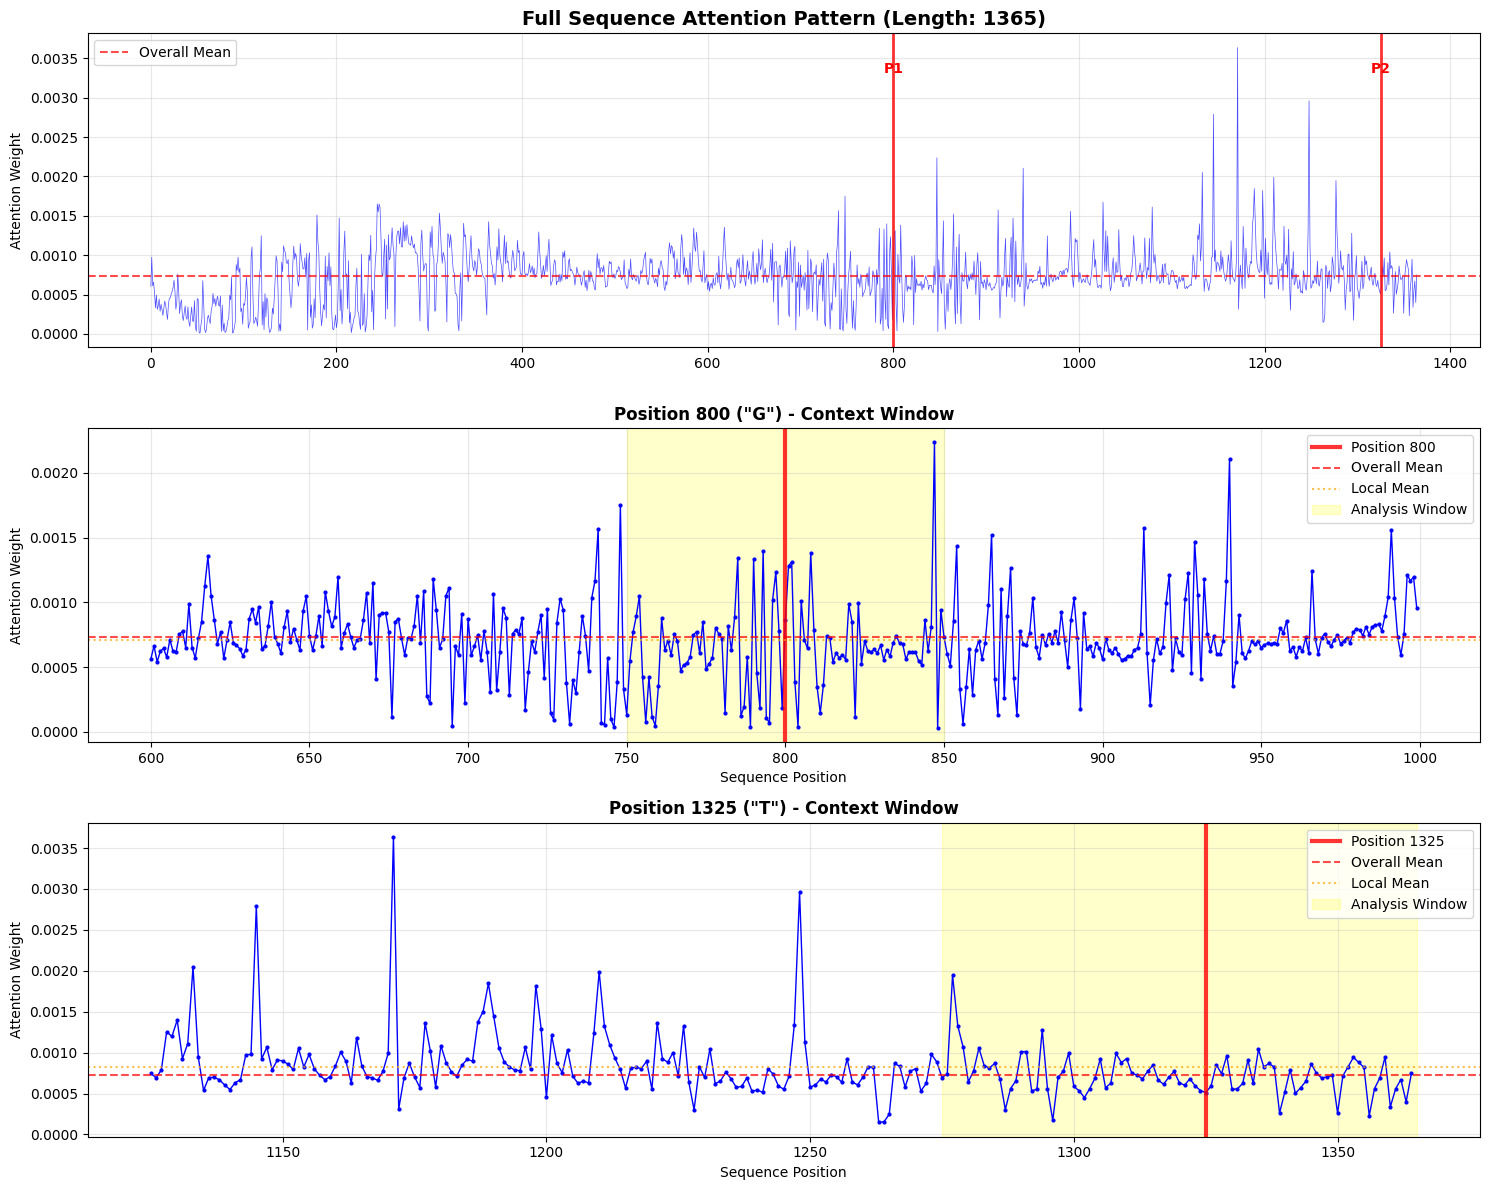


4. SUMMARY OF FINDINGS
Position Analysis Summary:
  Position 800 (G):
    - Attention level: 0.87x the sequence average
    - Z-score: -0.27 (above 0.0% of sequence)
    - ➡️  SIMILAR attention to average
  Position 1325 (T):
    - Attention level: 0.99x the sequence average
    - Z-score: -0.03 (above 0.0% of sequence)
    - ➡️  SIMILAR attention to average

5. TOP ATTENTION POSITIONS FOR COMPARISON
{'Biological': '0.372', 'Chimeric Artifact': '0.628'}
Top 10 attention positions:
 1. Position 1171: 'C' (weight: 0.0036)
 2. Position 1248: 'C' (weight: 0.0030)
 3. Position 1145: 'C' (weight: 0.0028)
 4. Position  847: 'C' (weight: 0.0022)
 5. Position  940: 'C' (weight: 0.0021)
 6. Position 1133: 'C' (weight: 0.0021)
 7. Position 1210: 'C' (weight: 0.0020)
 8. Position 1277: 'G' (weight: 0.0019)
 9. Position 1189: 'G' (weight: 0.0018)
10. Position 1198: 'G' (weight: 0.0018)
ℹ️  None of the biological positions are in the top 10 attention positions
   This suggests they may have average

In [60]:
r1 = next(chimeric_reads)
show_attention_with_biological_pos(r1)

In [20]:
# Statistical Testing Framework for Position Analysis
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway, mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests


class StatisticalPositionAnalyzer:
    """Statistical analysis of attention patterns at specific positions."""

    def __init__(self):
        self.results = {}

    def extract_attention_data(self, sequence: str, positions: List[int], window_size: int = 50) -> Dict:
        """
        Extract attention weights for positions and their windows.

        Args:
            sequence: DNA sequence
            positions: List of positions to analyze
            window_size: Size of window around each position

        Returns:
            Dictionary with attention data for statistical analysis
        """
        # Get attention weights using existing analyzer
        weights = bio_analyzer.attention_weights(sequence)[1]
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()
        weights = weights[:-1]  # Remove CLS token

        seq_length = len(sequence)
        weights_length = len(weights)
        min_length = min(seq_length, weights_length)

        # Validate positions
        valid_positions = [pos for pos in positions if 0 <= pos < min_length]

        # Extract data for each position
        position_data = {}
        for pos in valid_positions:
            # Position-specific attention
            position_attention = weights[pos]

            # Window around position
            start = max(0, pos - window_size // 2)
            end = min(min_length, pos + window_size // 2)
            window_attention = weights[start:end]

            # Background (rest of sequence excluding window)
            background_mask = np.ones(min_length, dtype=bool)
            background_mask[start:end] = False
            background_attention = weights[background_mask]

            position_data[pos] = {
                "position_attention": position_attention,
                "window_attention": window_attention,
                "background_attention": background_attention,
                "window_start": start,
                "window_end": end,
                "nucleotide": sequence[pos],
            }

        return {
            "position_data": position_data,
            "all_attention": weights,
            "sequence_length": min_length,
            "window_size": window_size,
        }

    def test_position_significance(self, attention_data: Dict, alpha: float = 0.05) -> Dict:
        """
        Test if positions have significantly different attention from background.

        Args:
            attention_data: Output from extract_attention_data
            alpha: Significance level

        Returns:
            Dictionary with statistical test results
        """
        results = {}

        for pos, data in attention_data["position_data"].items():
            pos_name = f"Position_{pos}"
            results[pos_name] = {}

            # Test 1: Position vs Background (one-sample t-test)
            # Compare single position attention to background distribution
            background_mean = np.mean(data["background_attention"])
            background_std = np.std(data["background_attention"])

            # Z-score for position attention
            if background_std > 0:
                z_score = (data["position_attention"] - background_mean) / background_std
                p_value_z = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Two-tailed
            else:
                z_score = 0
                p_value_z = 1.0

            results[pos_name]["position_vs_background"] = {
                "test_type": "z_test",
                "position_attention": data["position_attention"],
                "background_mean": background_mean,
                "background_std": background_std,
                "z_score": z_score,
                "p_value": p_value_z,
                "significant": p_value_z < alpha,
                "effect_size": abs(z_score),  # Effect size as absolute z-score
            }

            # Test 2: Window vs Background (two-sample t-test)
            if len(data["window_attention"]) > 1:
                # Independent t-test
                t_stat, p_value_t = ttest_ind(
                    data["window_attention"],
                    data["background_attention"],
                    equal_var=False,  # Welch's t-test
                )

                # Mann-Whitney U test (non-parametric alternative)
                u_stat, p_value_mw = mannwhitneyu(
                    data["window_attention"], data["background_attention"], alternative="two-sided"
                )

                # Effect size (Cohen's d)
                pooled_std = np.sqrt(
                    (
                        (len(data["window_attention"]) - 1) * np.var(data["window_attention"], ddof=1)
                        + (len(data["background_attention"]) - 1) * np.var(data["background_attention"], ddof=1)
                    )
                    / (len(data["window_attention"]) + len(data["background_attention"]) - 2)
                )

                cohens_d = (
                    (np.mean(data["window_attention"]) - np.mean(data["background_attention"])) / pooled_std
                    if pooled_std > 0
                    else 0
                )

                results[pos_name]["window_vs_background"] = {
                    "test_type": "two_sample_t_test",
                    "window_mean": np.mean(data["window_attention"]),
                    "window_std": np.std(data["window_attention"]),
                    "background_mean": np.mean(data["background_attention"]),
                    "background_std": np.std(data["background_attention"]),
                    "t_statistic": t_stat,
                    "p_value_ttest": p_value_t,
                    "u_statistic": u_stat,
                    "p_value_mannwhitney": p_value_mw,
                    "cohens_d": cohens_d,
                    "significant_ttest": p_value_t < alpha,
                    "significant_mannwhitney": p_value_mw < alpha,
                }
            else:
                results[pos_name]["window_vs_background"] = {"error": "Window too small for statistical testing"}

        return results

    def multiple_testing_correction(self, results: Dict, method: str = "bonferroni") -> Dict:
        """
        Apply multiple testing correction to p-values.

        Args:
            results: Output from test_position_significance
            method: Correction method ('bonferroni', 'fdr_bh', 'fdr_by', 'holm')

        Returns:
            Results with corrected p-values
        """
        # Collect all p-values
        p_values = []
        test_keys = []

        for pos_name, pos_results in results.items():
            if "position_vs_background" in pos_results:
                p_values.append(pos_results["position_vs_background"]["p_value"])
                test_keys.append((pos_name, "position_vs_background"))

            if "window_vs_background" in pos_results and "p_value_ttest" in pos_results["window_vs_background"]:
                p_values.append(pos_results["window_vs_background"]["p_value_ttest"])
                test_keys.append((pos_name, "window_vs_background_ttest"))

                p_values.append(pos_results["window_vs_background"]["p_value_mannwhitney"])
                test_keys.append((pos_name, "window_vs_background_mannwhitney"))

        if not p_values:
            return results

        # Apply correction
        corrected_p_values = multipletests(p_values, method=method)[1]

        # Update results
        for i, (pos_name, test_type) in enumerate(test_keys):
            if test_type == "position_vs_background":
                results[pos_name]["position_vs_background"]["p_value_corrected"] = corrected_p_values[i]
                results[pos_name]["position_vs_background"]["significant_corrected"] = corrected_p_values[i] < 0.05
            elif test_type == "window_vs_background_ttest":
                results[pos_name]["window_vs_background"]["p_value_ttest_corrected"] = corrected_p_values[i]
                results[pos_name]["window_vs_background"]["significant_ttest_corrected"] = corrected_p_values[i] < 0.05
            elif test_type == "window_vs_background_mannwhitney":
                results[pos_name]["window_vs_background"]["p_value_mannwhitney_corrected"] = corrected_p_values[i]
                results[pos_name]["window_vs_background"]["significant_mannwhitney_corrected"] = (
                    corrected_p_values[i] < 0.05
                )

        return results

    def compare_positions(self, attention_data: Dict, alpha: float = 0.05) -> Dict:
        """
        Compare attention between different positions using ANOVA.

        Args:
            attention_data: Output from extract_attention_data
            alpha: Significance level

        Returns:
            ANOVA results and pairwise comparisons
        """
        # Collect window attention data for all positions
        position_windows = []
        position_labels = []

        for pos, data in attention_data["position_data"].items():
            position_windows.append(data["window_attention"])
            position_labels.append(f"Pos_{pos}")

        if len(position_windows) < 2:
            return {"error": "Need at least 2 positions for comparison"}

        # One-way ANOVA
        f_stat, p_value_anova = f_oneway(*position_windows)

        # Calculate effect size (eta-squared)
        all_windows = np.concatenate(position_windows)
        grand_mean = np.mean(all_windows)

        ss_between = sum(len(window) * (np.mean(window) - grand_mean) ** 2 for window in position_windows)
        ss_total = np.sum((all_windows - grand_mean) ** 2)
        eta_squared = ss_between / ss_total if ss_total > 0 else 0

        # Pairwise comparisons (t-tests)
        pairwise_results = {}
        n_comparisons = len(position_labels) * (len(position_labels) - 1) // 2

        for i in range(len(position_labels)):
            for j in range(i + 1, len(position_labels)):
                pos_i, pos_j = position_labels[i], position_labels[j]
                window_i, window_j = position_windows[i], position_windows[j]

                t_stat, p_value = ttest_ind(window_i, window_j, equal_var=False)

                # Bonferroni correction for pairwise comparisons
                p_value_corrected = min(p_value * n_comparisons, 1.0)

                pairwise_results[f"{pos_i}_vs_{pos_j}"] = {
                    "t_statistic": t_stat,
                    "p_value": p_value,
                    "p_value_corrected": p_value_corrected,
                    "significant": p_value_corrected < alpha,
                    "mean_diff": np.mean(window_i) - np.mean(window_j),
                }

        return {
            "anova": {
                "f_statistic": f_stat,
                "p_value": p_value_anova,
                "eta_squared": eta_squared,
                "significant": p_value_anova < alpha,
            },
            "pairwise_comparisons": pairwise_results,
            "n_positions": len(position_labels),
            "n_comparisons": n_comparisons,
        }

    def generate_report(self, results: Dict, comparison_results: Dict = None) -> str:
        """
        Generate a comprehensive statistical report.

        Args:
            results: Output from test_position_significance (with corrections)
            comparison_results: Output from compare_positions

        Returns:
            Formatted report string
        """
        report = []
        report.append("=" * 80)
        report.append("STATISTICAL ANALYSIS REPORT")
        report.append("=" * 80)

        # Individual position tests
        report.append("\n1. POSITION SIGNIFICANCE TESTS")
        report.append("-" * 50)

        significant_positions = []

        for pos_name, pos_results in results.items():
            pos_num = pos_name.split("_")[1]
            nucleotide = pos_results.get("nucleotide", "Unknown")

            report.append(f"\nPosition {pos_num} ({nucleotide}):")

            # Position vs background
            if "position_vs_background" in pos_results:
                pos_test = pos_results["position_vs_background"]
                report.append(f"  Position vs Background (Z-test):")
                report.append(f"    - Position attention: {pos_test['position_attention']:.4f}")
                report.append(
                    f"    - Background mean: {pos_test['background_mean']:.4f} ± {pos_test['background_std']:.4f}"
                )
                report.append(f"    - Z-score: {pos_test['z_score']:.2f}")
                report.append(f"    - P-value: {pos_test['p_value']:.4f}")
                if "p_value_corrected" in pos_test:
                    report.append(f"    - P-value (corrected): {pos_test['p_value_corrected']:.4f}")
                    significant = pos_test["significant_corrected"]
                else:
                    significant = pos_test["significant"]
                report.append(f"    - Significant: {'Yes' if significant else 'No'}")

                if significant:
                    significant_positions.append(pos_num)

            # Window vs background
            if "window_vs_background" in pos_results and "error" not in pos_results["window_vs_background"]:
                window_test = pos_results["window_vs_background"]
                report.append(f"  Window vs Background:")
                report.append(f"    - Window mean: {window_test['window_mean']:.4f} ± {window_test['window_std']:.4f}")
                report.append(
                    f"    - Background mean: {window_test['background_mean']:.4f} ± {window_test['background_std']:.4f}"
                )
                report.append(f"    - Cohen's d: {window_test['cohens_d']:.2f}")

                # T-test results
                report.append(f"    - T-test p-value: {window_test['p_value_ttest']:.4f}")
                if "p_value_ttest_corrected" in window_test:
                    report.append(f"    - T-test p-value (corrected): {window_test['p_value_ttest_corrected']:.4f}")
                    ttest_sig = window_test["significant_ttest_corrected"]
                else:
                    ttest_sig = window_test["significant_ttest"]
                report.append(f"    - T-test significant: {'Yes' if ttest_sig else 'No'}")

                # Mann-Whitney results
                report.append(f"    - Mann-Whitney p-value: {window_test['p_value_mannwhitney']:.4f}")
                if "p_value_mannwhitney_corrected" in window_test:
                    report.append(
                        f"    - Mann-Whitney p-value (corrected): {window_test['p_value_mannwhitney_corrected']:.4f}"
                    )
                    mw_sig = window_test["significant_mannwhitney_corrected"]
                else:
                    mw_sig = window_test["significant_mannwhitney"]
                report.append(f"    - Mann-Whitney significant: {'Yes' if mw_sig else 'No'}")

        # Summary
        report.append(f"\nSUMMARY:")
        report.append(f"  - Total positions tested: {len(results)}")
        report.append(f"  - Significantly different positions: {len(significant_positions)}")
        if significant_positions:
            report.append(f"  - Significant positions: {', '.join(significant_positions)}")

        # Position comparisons
        if comparison_results and "error" not in comparison_results:
            report.append("\n2. POSITION COMPARISONS")
            report.append("-" * 50)

            anova = comparison_results["anova"]
            report.append(f"ANOVA Results:")
            report.append(f"  - F-statistic: {anova['f_statistic']:.2f}")
            report.append(f"  - P-value: {anova['p_value']:.4f}")
            report.append(f"  - Effect size (η²): {anova['eta_squared']:.3f}")
            report.append(f"  - Significant differences: {'Yes' if anova['significant'] else 'No'}")

            if anova["significant"]:
                report.append(f"\nPairwise Comparisons (Bonferroni corrected):")
                for comparison, result in comparison_results["pairwise_comparisons"].items():
                    status = "Significant" if result["significant"] else "Not significant"
                    report.append(
                        f"  - {comparison}: {status} (p={result['p_value_corrected']:.4f}, diff={result['mean_diff']:.4f})"
                    )

        return "\n".join(report)


# Create statistical analyzer instance
stat_analyzer = StatisticalPositionAnalyzer()

In [21]:
# Statistical Visualization Methods
class StatisticalVisualizer:
    """Visualization methods for statistical analysis results."""

    def plot_position_comparison(
        self, attention_data: Dict, results: Dict, figsize: Tuple[int, int] = (15, 10)
    ) -> None:
        """
        Create comprehensive visualization of position analysis results.

        Args:
            attention_data: Output from extract_attention_data
            results: Output from test_position_significance
            figsize: Figure size tuple
        """
        import matplotlib.pyplot as plt
        import seaborn as sns

        n_positions = len(attention_data["position_data"])

        fig, axes = plt.subplots(3, 2, figsize=figsize)
        fig.suptitle("Statistical Analysis of Position Attention Patterns", fontsize=16, fontweight="bold")

        # 1. Overall attention pattern with positions marked
        ax1 = axes[0, 0]
        all_attention = attention_data["all_attention"]
        ax1.plot(range(len(all_attention)), all_attention, "b-", alpha=0.7, linewidth=0.8)
        ax1.axhline(y=np.mean(all_attention), color="r", linestyle="--", alpha=0.7, label="Overall Mean")

        # Mark positions of interest
        colors = plt.cm.Set1(np.linspace(0, 1, n_positions))
        for i, (pos, data) in enumerate(attention_data["position_data"].items()):
            ax1.axvline(x=pos, color=colors[i], linestyle="-", linewidth=2, alpha=0.8)
            ax1.text(
                pos,
                np.max(all_attention) * 0.9,
                f"P{pos}",
                ha="center",
                va="bottom",
                fontsize=10,
                fontweight="bold",
                color=colors[i],
            )

        ax1.set_title("Full Sequence with Marked Positions")
        ax1.set_xlabel("Position")
        ax1.set_ylabel("Attention Weight")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Box plots comparing positions
        ax2 = axes[0, 1]
        position_data_for_box = []
        position_labels = []

        for pos, data in attention_data["position_data"].items():
            position_data_for_box.append(data["window_attention"])
            position_labels.append(f"Pos {pos}")

        bp = ax2.boxplot(position_data_for_box, labels=position_labels, patch_artist=True)
        ax2.axhline(y=np.mean(all_attention), color="r", linestyle="--", alpha=0.7, label="Overall Mean")

        # Color boxes
        for patch, color in zip(bp["boxes"], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax2.set_title("Attention Distribution by Position")
        ax2.set_ylabel("Attention Weight")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Z-scores for each position
        ax3 = axes[1, 0]
        positions = []
        z_scores = []
        p_values = []

        for pos_name, pos_results in results.items():
            if "position_vs_background" in pos_results:
                pos_num = int(pos_name.split("_")[1])
                positions.append(pos_num)
                z_scores.append(pos_results["position_vs_background"]["z_score"])
                p_values.append(pos_results["position_vs_background"]["p_value"])

        bars = ax3.bar(positions, z_scores, color=colors[: len(positions)], alpha=0.7)
        ax3.axhline(y=1.96, color="r", linestyle="--", alpha=0.7, label="Significance threshold (±1.96)")
        ax3.axhline(y=-1.96, color="r", linestyle="--", alpha=0.7)
        ax3.axhline(y=0, color="k", linestyle="-", alpha=0.5)

        # Add significance indicators
        for i, (bar, p_val) in enumerate(zip(bars, p_values)):
            height = bar.get_height()
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
            ax3.text(
                bar.get_x() + bar.get_width() / 2,
                height + (0.1 if height >= 0 else -0.1),
                significance,
                ha="center",
                va="bottom" if height >= 0 else "top",
                fontweight="bold",
            )

        ax3.set_title("Z-scores for Position vs Background")
        ax3.set_xlabel("Position")
        ax3.set_ylabel("Z-score")
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. P-values (log scale)
        ax4 = axes[1, 1]
        p_values_log = [-np.log10(p) for p in p_values]
        bars = ax4.bar(positions, p_values_log, color=colors[: len(positions)], alpha=0.7)
        ax4.axhline(y=-np.log10(0.05), color="r", linestyle="--", alpha=0.7, label="α = 0.05")
        ax4.axhline(y=-np.log10(0.01), color="orange", linestyle="--", alpha=0.7, label="α = 0.01")

        ax4.set_title("P-values (log scale)")
        ax4.set_xlabel("Position")
        ax4.set_ylabel("-log₁₀(p-value)")
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        # 5. Effect sizes (Cohen's d)
        ax5 = axes[2, 0]
        effect_sizes = []

        for pos_name, pos_results in results.items():
            if "window_vs_background" in pos_results and "cohens_d" in pos_results["window_vs_background"]:
                effect_sizes.append(pos_results["window_vs_background"]["cohens_d"])
            else:
                effect_sizes.append(0)

        bars = ax5.bar(positions, effect_sizes, color=colors[: len(positions)], alpha=0.7)
        ax5.axhline(y=0.2, color="orange", linestyle="--", alpha=0.7, label="Small effect (0.2)")
        ax5.axhline(y=0.5, color="r", linestyle="--", alpha=0.7, label="Medium effect (0.5)")
        ax5.axhline(y=0.8, color="darkred", linestyle="--", alpha=0.7, label="Large effect (0.8)")
        ax5.axhline(y=0, color="k", linestyle="-", alpha=0.5)

        ax5.set_title("Effect Sizes (Cohen's d)")
        ax5.set_xlabel("Position")
        ax5.set_ylabel("Cohen's d")
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        # 6. Summary statistics table
        ax6 = axes[2, 1]
        ax6.axis("off")

        # Create summary table
        table_data = []
        for i, pos in enumerate(positions):
            pos_name = f"Position_{pos}"
            if pos_name in results:
                pos_results = results[pos_name]
                if "position_vs_background" in pos_results:
                    z_score = pos_results["position_vs_background"]["z_score"]
                    p_val = pos_results["position_vs_background"]["p_value"]
                    significant = "Yes" if p_val < 0.05 else "No"

                    if "window_vs_background" in pos_results and "cohens_d" in pos_results["window_vs_background"]:
                        cohens_d = pos_results["window_vs_background"]["cohens_d"]
                    else:
                        cohens_d = "N/A"

                    table_data.append(
                        [
                            f"Pos {pos}",
                            f"{z_score:.2f}",
                            f"{p_val:.4f}",
                            significant,
                            f"{cohens_d:.2f}" if cohens_d != "N/A" else "N/A",
                        ]
                    )

        table = ax6.table(
            cellText=table_data,
            colLabels=["Position", "Z-score", "P-value", "Significant", "Cohen's d"],
            cellLoc="center",
            loc="center",
            bbox=[0, 0, 1, 1],
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)

        ax6.set_title("Summary Statistics", fontsize=12, fontweight="bold", pad=20)

        plt.tight_layout()
        plt.show()

    def plot_attention_distributions(self, attention_data: Dict, results: Dict) -> None:
        """Plot detailed attention distributions for each position."""
        import matplotlib.pyplot as plt

        n_positions = len(attention_data["position_data"])
        fig, axes = plt.subplots(2, (n_positions + 1) // 2, figsize=(5 * ((n_positions + 1) // 2), 10))
        if n_positions == 1:
            axes = [axes]
        elif n_positions == 2:
            axes = axes
        else:
            axes = axes.flatten()

        colors = plt.cm.Set1(np.linspace(0, 1, n_positions))

        for i, (pos, data) in enumerate(attention_data["position_data"].items()):
            ax = axes[i] if n_positions > 1 else axes[0]

            # Plot distributions
            ax.hist(
                data["background_attention"], bins=50, alpha=0.5, color="lightblue", label="Background", density=True
            )
            ax.hist(
                data["window_attention"], bins=30, alpha=0.7, color=colors[i], label=f"Window (Pos {pos})", density=True
            )

            # Mark position attention
            ax.axvline(
                data["position_attention"], color="red", linestyle="-", linewidth=3, label=f"Position {pos}", alpha=0.8
            )

            # Mark means
            ax.axvline(
                np.mean(data["background_attention"]), color="blue", linestyle="--", label="Background mean", alpha=0.7
            )
            ax.axvline(
                np.mean(data["window_attention"]), color=colors[i], linestyle="--", label="Window mean", alpha=0.7
            )

            # Add statistics
            pos_name = f"Position_{pos}"
            if pos_name in results and "window_vs_background" in results[pos_name]:
                test_results = results[pos_name]["window_vs_background"]
                if "p_value_ttest" in test_results:
                    p_val = test_results["p_value_ttest"]
                    cohens_d = test_results.get("cohens_d", 0)
                    ax.text(
                        0.02,
                        0.98,
                        f"p = {p_val:.4f}\nCohen's d = {cohens_d:.2f}",
                        transform=ax.transAxes,
                        verticalalignment="top",
                        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
                    )

            ax.set_title(f"Position {pos} Attention Distribution")
            ax.set_xlabel("Attention Weight")
            ax.set_ylabel("Density")
            ax.legend()
            ax.grid(True, alpha=0.3)

        # Hide unused subplots
        if n_positions < len(axes):
            for j in range(n_positions, len(axes)):
                axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

    def plot_anova_results(self, attention_data: Dict, comparison_results: Dict) -> None:
        """Plot ANOVA and pairwise comparison results."""
        import matplotlib.pyplot as plt
        import seaborn as sns

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # 1. ANOVA effect size
        ax1 = axes[0]
        anova = comparison_results["anova"]
        eta_squared = anova["eta_squared"]

        bars = ax1.bar(["ANOVA"], [eta_squared], color="steelblue", alpha=0.7)
        ax1.axhline(y=0.01, color="orange", linestyle="--", alpha=0.7, label="Small (0.01)")
        ax1.axhline(y=0.06, color="r", linestyle="--", alpha=0.7, label="Medium (0.06)")
        ax1.axhline(y=0.14, color="darkred", linestyle="--", alpha=0.7, label="Large (0.14)")

        ax1.set_title(f"ANOVA Effect Size (η² = {eta_squared:.3f})")
        ax1.set_ylabel("Effect Size (η²)")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Pairwise comparison p-values
        ax2 = axes[1]
        comparisons = list(comparison_results["pairwise_comparisons"].keys())
        p_values = [comparison_results["pairwise_comparisons"][comp]["p_value"] for comp in comparisons]
        p_values_corrected = [
            comparison_results["pairwise_comparisons"][comp]["p_value_corrected"] for comp in comparisons
        ]

        x = np.arange(len(comparisons))
        width = 0.35

        bars1 = ax2.bar(x - width / 2, p_values, width, label="Original p-values", alpha=0.7, color="lightblue")
        bars2 = ax2.bar(
            x + width / 2, p_values_corrected, width, label="Bonferroni corrected", alpha=0.7, color="orange"
        )

        ax2.axhline(y=0.05, color="r", linestyle="--", alpha=0.7, label="α = 0.05")
        ax2.set_title("Pairwise Comparison P-values")
        ax2.set_xlabel("Comparisons")
        ax2.set_ylabel("P-value")
        ax2.set_xticks(x)
        ax2.set_xticklabels([comp.replace("_vs_", " vs ") for comp in comparisons], rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Mean differences
        ax3 = axes[2]
        mean_diffs = [comparison_results["pairwise_comparisons"][comp]["mean_diff"] for comp in comparisons]
        colors = ["green" if diff > 0 else "red" for diff in mean_diffs]

        bars = ax3.bar(comparisons, mean_diffs, color=colors, alpha=0.7)
        ax3.axhline(y=0, color="k", linestyle="-", alpha=0.5)
        ax3.set_title("Mean Differences (Window Attention)")
        ax3.set_xlabel("Comparisons")
        ax3.set_ylabel("Mean Difference")
        ax3.set_xticklabels([comp.replace("_vs_", " vs ") for comp in comparisons], rotation=45)
        ax3.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


# Create visualization instance
stat_visualizer = StatisticalVisualizer()

In [229]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pysam
import numpy as np
from typing import Tuple, Optional


def viz_sv_inversion_event(read: pysam.AlignedSegment, sv: Tuple[str, int, str, int, int, str]):
    """
    Single integrated figure showing nanopore long read vs reference alignment

    Args:
        read: pysam.AlignedSegment supporting the inversion (nanopore long read)
        sv: tuple containing (chr1, pos1, chr2, pos2, svlen, strand)
    """
    chr1, pos1, chr2, pos2, svlen, strand = sv

    if chr1 != chr2:
        raise ValueError("Inversion events should occur on the same chromosome")

    # Calculate total read length from all segments
    total_read_length = calculate_total_read_length(read)

    # Set up single figure
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    fig.suptitle(f"Nanopore Long Read Analysis: {total_read_length:,}bp Read Spanning Inversion", fontsize=16)

    # Define region
    window = max(svlen // 4, 5000)
    start_region = min(pos1, pos2) - window
    end_region = max(pos1, pos2) + window
    inv_start, inv_end = min(pos1, pos2), max(pos1, pos2)

    ax.set_xlim(start_region, end_region)
    ax.set_ylim(0, 10)
    ax.grid(True, alpha=0.3)

    # Y-axis positions for different tracks
    ref_y = 8.5
    donor_genome_y = 7.0
    donor_read_y = 5.5
    ref_align_y = 3.5

    # === REFERENCE GENOME TRACK ===
    ax.plot([start_region, end_region], [ref_y, ref_y], "b-", linewidth=10, alpha=0.7, label="Reference Genome")

    # Mark breakpoints
    ax.axvline(pos1, color="red", linestyle="--", linewidth=3, alpha=0.8, label="Breakpoints")
    ax.axvline(pos2, color="red", linestyle="--", linewidth=3, alpha=0.8)

    # Breakpoint labels
    ax.text(
        pos1,
        ref_y + 0.4,
        f"BP1: {pos1:,}",
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", edgecolor="red"),
    )
    ax.text(
        pos2,
        ref_y + 0.4,
        f"BP2: {pos2:,}",
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", edgecolor="red"),
    )

    # === DONOR GENOME TRACK ===
    # Normal regions
    ax.plot(
        [start_region, inv_start], [donor_genome_y, donor_genome_y], "g-", linewidth=10, alpha=0.7, label="Donor Normal"
    )
    ax.plot([inv_end, end_region], [donor_genome_y, donor_genome_y], "g-", linewidth=10, alpha=0.7)

    # Inverted region
    ax.plot(
        [inv_start, inv_end], [donor_genome_y, donor_genome_y], "r-", linewidth=10, alpha=0.7, label="Donor Inverted"
    )

    # Inversion arrows
    mid_inv = (inv_start + inv_end) / 2
    arrow_len = (inv_end - inv_start) * 0.15
    ax.annotate(
        "",
        xy=(mid_inv - arrow_len, donor_genome_y - 0.3),
        xytext=(mid_inv + arrow_len, donor_genome_y - 0.3),
        arrowprops=dict(arrowstyle="<->", color="red", lw=3),
    )
    ax.text(mid_inv, donor_genome_y - 0.6, "INVERTED", ha="center", color="red", fontweight="bold", fontsize=12)

    # === DONOR READ TRACK ===
    # Show the read as it exists in donor (contiguous)
    donor_read_pos = estimate_donor_read_position(read, pos1, pos2)
    donor_rect = patches.Rectangle(
        (donor_read_pos, donor_read_y - 0.15),
        total_read_length,
        0.3,
        facecolor="purple",
        alpha=0.8,
        edgecolor="black",
        linewidth=2,
        label=f"Donor Read ({total_read_length}bp)",
    )
    ax.add_patch(donor_rect)

    # Read direction arrow
    ax.text(
        donor_read_pos + total_read_length / 2,
        donor_read_y,
        "▶",
        ha="center",
        va="center",
        color="white",
        fontsize=16,
        fontweight="bold",
    )

    ax.text(
        donor_read_pos + total_read_length + 1000,
        donor_read_y,
        f"Single {total_read_length:,}bp nanopore read",
        ha="left",
        va="center",
        fontweight="bold",
        fontsize=11,
        color="purple",
    )

    # === REFERENCE ALIGNMENT TRACK ===
    ax.text(
        start_region - 2000,
        ref_align_y - 1.0,
        "Key: Long read splits into multiple segments when aligned to reference",
        ha="right",
        va="center",
        fontweight="bold",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
    )

    # === REFERENCE ALIGNMENT TRACK ===
    # Plot all segments of the actual read
    segments = get_all_read_segments(read)
    colors = ["darkgreen", "red", "orange", "brown"]
    total_mapped_length = 0
    segment_labels = []

    for i, segment in enumerate(segments):
        if segment["chr"] != read.reference_name:
            continue

        color = colors[i % len(colors)]
        seg_rect = patches.Rectangle(
            (segment["start"], ref_align_y - 0.15),
            segment["length"],
            0.3,
            facecolor=color,
            alpha=0.9,
            edgecolor="black",
            linewidth=2,
        )
        ax.add_patch(seg_rect)

        # Segment type and length
        segment_type = "P" if segment["is_primary"] else "S"
        ax.text(
            segment["start"] + segment["length"] / 2,
            ref_align_y,
            segment_type,
            ha="center",
            va="center",
            color="white",
            fontsize=14,
            fontweight="bold",
        )

        segment_labels.append(f"{segment_type}:{segment['length']}bp")
        total_mapped_length += segment["length"]

        # Connection lines between segments
        if i > 0 and len(segments) > 1:
            prev_seg = segments[i - 1]
            if prev_seg["chr"] == segment["chr"]:
                # Curved connection
                connection_y = ref_align_y + 0.5
                ax.plot(
                    [
                        prev_seg["start"] + prev_seg["length"],
                        prev_seg["start"] + prev_seg["length"],
                        segment["start"],
                        segment["start"],
                    ],
                    [ref_align_y + 0.15, connection_y, connection_y, ref_align_y + 0.15],
                    "purple",
                    linewidth=3,
                    alpha=0.8,
                )
                ax.text(
                    (prev_seg["start"] + prev_seg["length"] + segment["start"]) / 2,
                    connection_y + 0.1,
                    "SAME READ",
                    ha="center",
                    fontsize=10,
                    color="purple",
                    fontweight="bold",
                )

    # Show length conservation equation
    segment_equation = " + ".join([f"{seg['length']}bp" for seg in segments if seg["chr"] == read.reference_name])
    ax.text(
        end_region - 5000,
        ref_align_y - 0.8,
        f"Length Conservation:\n{segment_equation} = {total_read_length}bp",
        ha="right",
        va="top",
        fontweight="bold",
        fontsize=11,
        bbox=dict(boxstyle="round,pad=0.4", facecolor="yellow", alpha=0.8),
    )

    # === TRACK LABELS ===
    ax.text(start_region - 2000, ref_y, "Reference\nGenome", ha="right", va="center", fontweight="bold", fontsize=12)
    ax.text(
        start_region - 2000, donor_genome_y, "Donor\nGenome", ha="right", va="center", fontweight="bold", fontsize=12
    )
    ax.text(
        start_region - 2000,
        donor_read_y,
        "Nanopore\nLong Read",
        ha="right",
        va="center",
        fontweight="bold",
        fontsize=12,
    )
    ax.text(
        start_region - 2000,
        ref_align_y,
        "Split Alignment\n(SA segments)",
        ha="right",
        va="center",
        fontweight="bold",
        fontsize=12,
    )

    # === CONNECTING ARROWS ===
    # Show how the same read maps differently
    ax.annotate(
        "",
        xy=(donor_read_pos + total_read_length / 2, ref_align_y + 0.3),
        xytext=(donor_read_pos + total_read_length / 2, donor_read_y - 0.3),
        arrowprops=dict(arrowstyle="->", color="purple", lw=3),
    )
    ax.text(
        donor_read_pos + total_read_length / 2 + 2000,
        (donor_read_y + ref_align_y) / 2,
        "SAME\nREAD",
        ha="center",
        va="center",
        fontweight="bold",
        fontsize=12,
        color="purple",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="purple"),
    )

    # === STYLING ===
    ax.set_xlabel(f"Genomic Position on {chr1}", fontsize=14, fontweight="bold")
    ax.set_ylabel("")
    ax.set_yticks([])

    # Legend
    ax.legend(loc="upper left", fontsize=11, framealpha=0.9)

    # Format x-axis
    ax.ticklabel_format(style="plain", axis="x")

    plt.tight_layout()
    return fig


def calculate_total_read_length(read: pysam.AlignedSegment) -> int:
    """Calculate the total original sequencing read length"""
    if read.query_length is not None:
        return read.query_length

    # Fallback: estimate from CIGAR
    total_length = 0
    if read.cigartuples:
        for op, length in read.cigartuples:
            if op in [0, 1, 4, 7, 8]:  # M, I, S, =, X consume query
                total_length += length

    return total_length if total_length > 0 else 8000  # Typical nanopore read length


def get_all_read_segments(read: pysam.AlignedSegment) -> list:
    """Get all alignment segments (primary + supplementary)"""
    segments = []

    # Primary segment
    segments.append(
        {
            "start": read.reference_start,
            "end": read.reference_end,
            "length": read.reference_end - read.reference_start,
            "is_primary": True,
            "chr": read.reference_name,
        }
    )

    # Supplementary segments
    if read.has_tag("SA"):
        sa_tag = read.get_tag("SA")
        for sa in sa_tag.rstrip(";").split(";"):
            if sa:
                parts = sa.split(",")
                if len(parts) >= 6:
                    sa_chr = parts[0]
                    sa_pos = int(parts[1])
                    sa_cigar = parts[3]
                    sa_length = calculate_reference_length_from_cigar(sa_cigar)

                    segments.append(
                        {
                            "start": sa_pos,
                            "end": sa_pos + sa_length,
                            "length": sa_length,
                            "is_primary": False,
                            "chr": sa_chr,
                        }
                    )

    return segments


def estimate_donor_read_position(read: pysam.AlignedSegment, bp1: int, bp2: int) -> int:
    """Estimate where the long read would be positioned in the donor sample"""
    # For nanopore reads, position to show it spans the entire inversion
    segments = get_all_read_segments(read)
    total_length = calculate_total_read_length(read)

    if segments:
        # Position read to span from before first segment to after last segment
        first_pos = min(seg["start"] for seg in segments if seg["chr"] == read.reference_name)
        last_pos = max(seg["end"] for seg in segments if seg["chr"] == read.reference_name)

        # Position to show read spanning the full region with some padding
        return first_pos - (total_length - (last_pos - first_pos)) // 2

    # Fallback: position to span both breakpoints
    return min(bp1, bp2) - total_length // 4


def calculate_reference_length_from_cigar(cigar_string: str) -> int:
    """Calculate reference length from CIGAR"""
    import re

    operations = re.findall(r"(\d+)([MIDNSHPX=])", cigar_string)
    ref_length = 0
    for length_str, op in operations:
        if op in ["M", "D", "N", "=", "X"]:
            ref_length += int(length_str)
    return ref_length


# Example usage
if __name__ == "__main__":
    # Example SV event
    example_sv = ("chr1", 1000000, "chr1", 1050000, 50000, "+")

    # You would call this with actual pysam read:
    # fig = viz_sv_inversion_event(supporting_read, example_sv)
    # plt.show()
    pass

In [130]:
# selected
# 8d99362e-b348-4031-b55a-cd2fb4ef43a3
# c938cba2-6cbd-4f98-bfa2-03ec43f631a8


# 6f4568e5-3543-48c7-a64b-f4010c03804c
# chr1        1584378 Sniffles2.INV.16E1S0    C       <INV>   60      PASS    PRECISE;SVTYPE=INV;SVLEN=1562;END
# =1585940;SUPPORT=1;RNAMES=6f4568e5-3543-48c7-a64b-f4010c03804c;COVERAGE=1,1,2,3,1;STRAND=-;STDEV_LEN=0;STDEV_POS=
# 0;VAF=1.000     GT:GQ:DR:DV     1/1:2:0:1

# chr1,1584378,chr1,1585940,1562,-

# 1c66d41b-de5a-4e3d-b54d-69d41bfc3160
# chr1        1123612 Sniffles2.INV.16D1S0    A       <INV>   60      PASS    PRECISE;SVTYPE=INV;SVLEN=3709;END
# =1127321;SUPPORT=1;RNAMES=1c66d41b-de5a-4e3d-b54d-69d41bfc3160;COVERAGE=0,0,1,1,1;STRAND=-;STDEV_LEN=0;STDEV_POS=
# 0;VAF=1.000     GT:GQ:DR:DV     1/1:2:0:1


# aed3bcc2-4e60-487d-afc5-8393918ef92d_1
# chr1        1191712 Sniffles2.INV.16D3S0    G       <INV>   60      GT      PRECISE;SVTYPE=INV;SVLEN=502;END=
# 1192214;SUPPORT=1;RNAMES=aed3bcc2-4e60-487d-afc5-8393918ef92d_1;COVERAGE=8,8,7,5,5;STRAND=+;STDEV_LEN=0;STDEV_POS
# =0;VAF=0.167    GT:GQ:DR:DV     0/0:3:5:1

## biological

# 8478ddb0-dc31-458e-aaf8-a2e87fc717f2

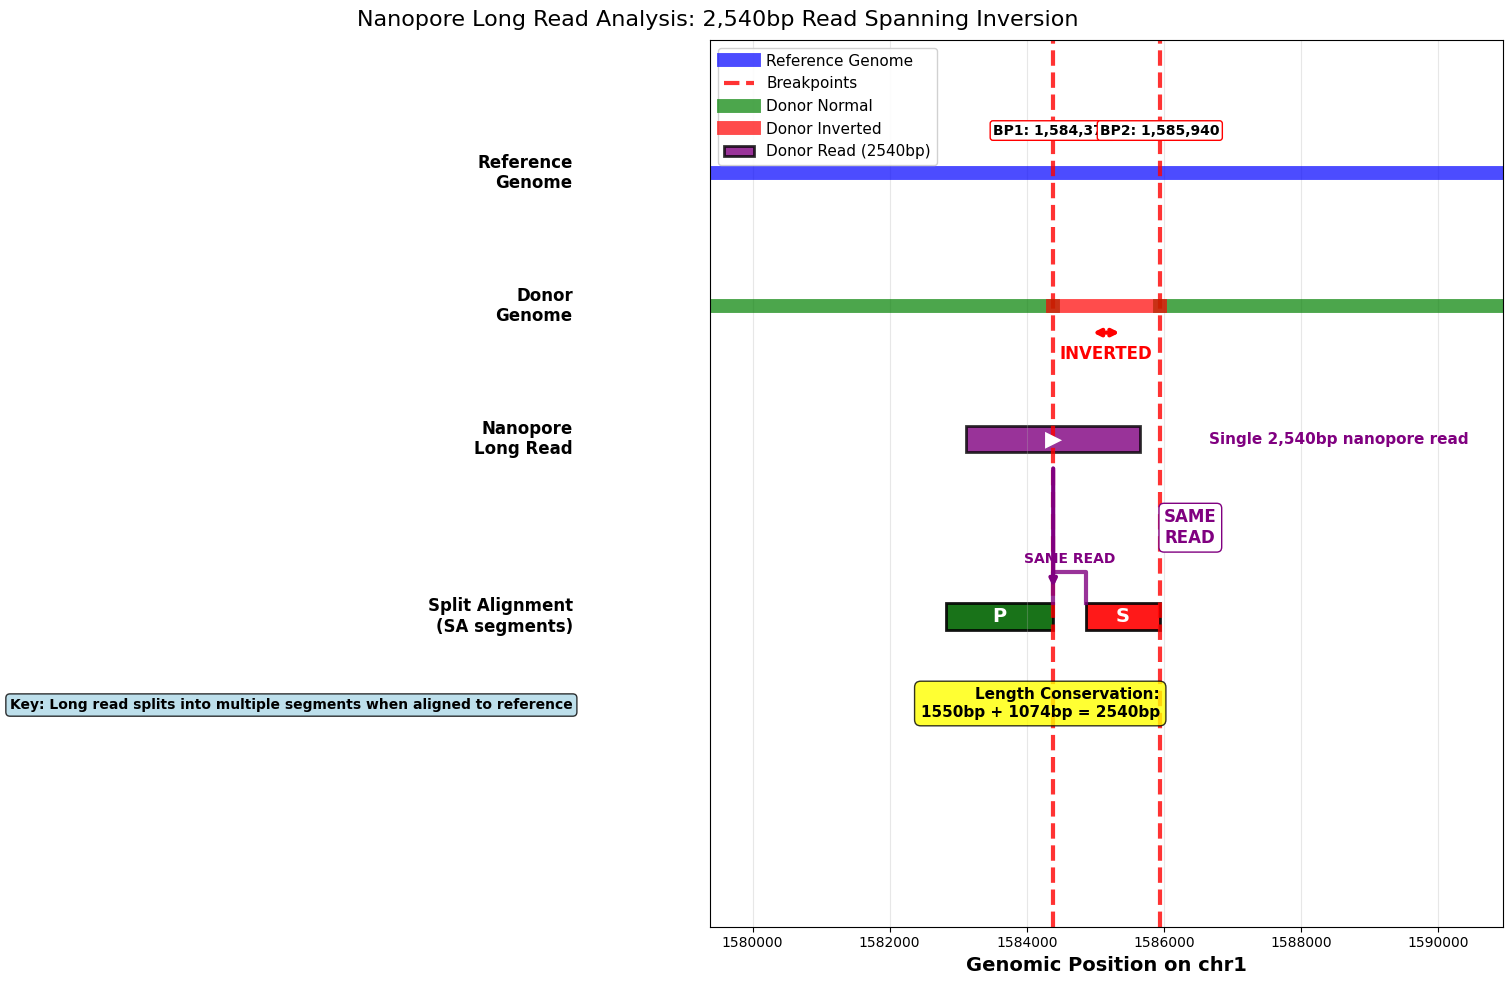

In [230]:
_ = viz_sv_inversion_event(chimeric_reads_dict[selected_read], ("chr1", 1584378, "chr1", 1585940, 1562, "-"))

=== WGA CHIMERIC ARTIFACT ANALYSIS ===
Read ID: 6f4568e5-3543-48c7-a64b-f4010c03804c
Total length: 2,540bp

=== ARTIFACT EVIDENCE ===
🚩 RED FLAGS suggesting WGA artifact:
  • Gap between alignments: 489bp
  • Strand orientations: reverse → forward
  • Complex CIGAR strings with extensive soft clipping
  • Perfect breakpoint correspondence (too clean?)

=== WGA ARTIFACT MECHANISM ===
1. During WGA amplification:
   Fragment A: chr1:1,582,828-1,584,378 (reverse strand)
   Fragment B: chr1:1,584,867-1,585,940 (forward strand)
   → Fragments get artificially joined during PCR

2. Creates chimeric molecule:
   [Fragment A]--artificial-join--[Fragment B]
   → Sequenced as single 'long' read
   → Mimics inversion signature when aligned

=== HOW TO DISTINGUISH REAL SV FROM WGA ARTIFACTS ===

WGA ARTIFACT INDICATORS:
❌ Isolated supporting reads (few reads, no cluster)
❌ Perfect, 'too clean' breakpoints
❌ Unusual gap sizes between segments
❌ High soft-clipping ratios
❌ Sample prepared with WGA
❌

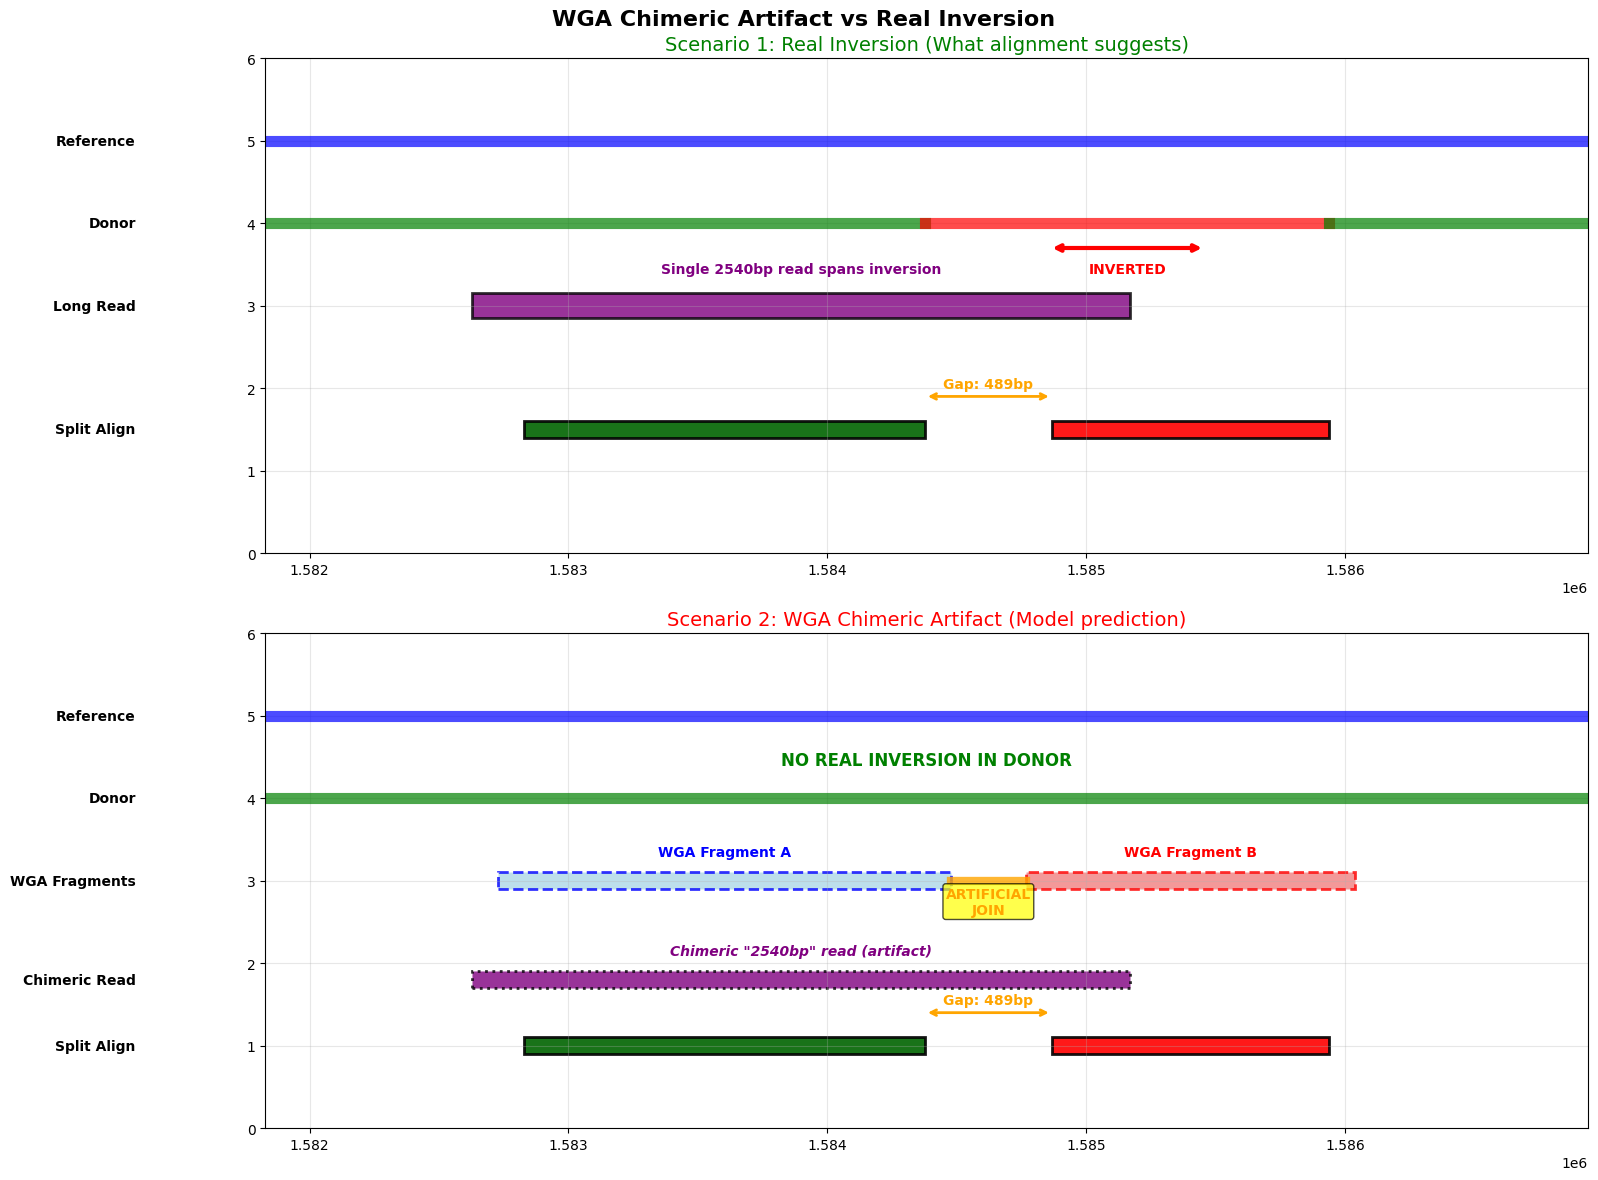

In [231]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def analyze_wga_chimeric_artifact():
    """
    Analyze read as potential WGA chimeric artifact vs real inversion
    """
    # Read details
    read_id = "6f4568e5-3543-48c7-a64b-f4010c03804c"
    total_read_length = 2540

    # Alignment segments
    primary_start = 1582828
    primary_end = 1584378
    primary_ref_length = 1550
    primary_strand = "reverse"

    sa_start = 1584867
    sa_ref_length = 1073
    sa_end = sa_start + sa_ref_length
    sa_strand = "forward"

    # Gap between segments
    gap_size = sa_start - primary_end  # 489bp gap

    print("=== WGA CHIMERIC ARTIFACT ANALYSIS ===")
    print(f"Read ID: {read_id}")
    print(f"Total length: {total_read_length:,}bp")
    print()

    print("=== ARTIFACT EVIDENCE ===")
    print("🚩 RED FLAGS suggesting WGA artifact:")
    print(f"  • Gap between alignments: {gap_size}bp")
    print(f"  • Strand orientations: {primary_strand} → {sa_strand}")
    print(f"  • Complex CIGAR strings with extensive soft clipping")
    print(f"  • Perfect breakpoint correspondence (too clean?)")
    print()

    print("=== WGA ARTIFACT MECHANISM ===")
    print("1. During WGA amplification:")
    print("   Fragment A: chr1:1,582,828-1,584,378 (reverse strand)")
    print("   Fragment B: chr1:1,584,867-1,585,940 (forward strand)")
    print("   → Fragments get artificially joined during PCR")
    print()
    print("2. Creates chimeric molecule:")
    print("   [Fragment A]--artificial-join--[Fragment B]")
    print("   → Sequenced as single 'long' read")
    print("   → Mimics inversion signature when aligned")
    print()

    # Create dual visualization: Real vs Artifact
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    fig.suptitle("WGA Chimeric Artifact vs Real Inversion", fontsize=16, fontweight="bold")

    # Common setup
    plot_start = primary_start - 1000
    plot_end = sa_end + 1000

    for ax in [ax1, ax2]:
        ax.set_xlim(plot_start, plot_end)
        ax.set_ylim(0, 6)
        ax.grid(True, alpha=0.3)

    # === TOP PANEL: REAL INVERSION SCENARIO ===
    ax1.set_title("Scenario 1: Real Inversion (What alignment suggests)", fontsize=14, color="green")

    # Reference genome
    ref_y = 5
    ax1.plot([plot_start, plot_end], [ref_y, ref_y], "b-", linewidth=8, alpha=0.7)

    # Donor genome with inversion
    donor_y = 4
    ax1.plot([plot_start, primary_end], [donor_y, donor_y], "g-", linewidth=8, alpha=0.7, label="Normal")
    ax1.plot([primary_end, sa_end], [donor_y, donor_y], "r-", linewidth=8, alpha=0.7, label="Inverted")
    ax1.plot([sa_end, plot_end], [donor_y, donor_y], "g-", linewidth=8, alpha=0.7)

    # Inversion arrows
    mid_inv = (primary_end + sa_end) / 2
    ax1.annotate(
        "",
        xy=(mid_inv - 300, donor_y - 0.3),
        xytext=(mid_inv + 300, donor_y - 0.3),
        arrowprops=dict(arrowstyle="<->", color="red", lw=3),
    )
    ax1.text(mid_inv, donor_y - 0.6, "INVERTED", ha="center", color="red", fontweight="bold")

    # Contiguous long read
    read_y = 3
    read_rect = patches.Rectangle(
        (primary_start - 200, read_y - 0.15),
        total_read_length,
        0.3,
        facecolor="purple",
        alpha=0.8,
        edgecolor="black",
        linewidth=2,
    )
    ax1.add_patch(read_rect)
    ax1.text(
        primary_start - 200 + total_read_length / 2,
        read_y + 0.4,
        f"Single {total_read_length}bp read spans inversion",
        ha="center",
        fontweight="bold",
        color="purple",
    )

    # Split alignment
    align_y = 1.5
    # Primary
    prim_rect = patches.Rectangle(
        (primary_start, align_y - 0.1),
        primary_ref_length,
        0.2,
        facecolor="darkgreen",
        alpha=0.9,
        edgecolor="black",
        linewidth=2,
    )
    ax1.add_patch(prim_rect)
    # SA
    sa_rect = patches.Rectangle(
        (sa_start, align_y - 0.1), sa_ref_length, 0.2, facecolor="red", alpha=0.9, edgecolor="black", linewidth=2
    )
    ax1.add_patch(sa_rect)

    ax1.text(plot_start - 500, ref_y, "Reference", ha="right", va="center", fontweight="bold")
    ax1.text(plot_start - 500, donor_y, "Donor", ha="right", va="center", fontweight="bold")
    ax1.text(plot_start - 500, read_y, "Long Read", ha="right", va="center", fontweight="bold")
    ax1.text(plot_start - 500, align_y, "Split Align", ha="right", va="center", fontweight="bold")

    # === BOTTOM PANEL: WGA ARTIFACT SCENARIO ===
    ax2.set_title("Scenario 2: WGA Chimeric Artifact (Model prediction)", fontsize=14, color="red")

    # Reference genome (normal - no inversion)
    ax2.plot([plot_start, plot_end], [ref_y, ref_y], "b-", linewidth=8, alpha=0.7, label="Reference (Normal)")

    # Donor genome (also normal - no real inversion)
    ax2.plot([plot_start, plot_end], [donor_y, donor_y], "g-", linewidth=8, alpha=0.7, label="Donor (Normal)")
    ax2.text(
        (plot_start + plot_end) / 2,
        donor_y + 0.4,
        "NO REAL INVERSION IN DONOR",
        ha="center",
        fontweight="bold",
        color="green",
        fontsize=12,
    )

    # WGA process creates artificial chimeric molecule
    wga_y = 3

    # Fragment A
    frag_a_start = primary_start - 100
    frag_a_rect = patches.Rectangle(
        (frag_a_start, wga_y - 0.1),
        primary_ref_length + 200,
        0.2,
        facecolor="lightblue",
        alpha=0.8,
        edgecolor="blue",
        linewidth=2,
        linestyle="--",
    )
    ax2.add_patch(frag_a_rect)
    ax2.text(
        frag_a_start + (primary_ref_length + 200) / 2,
        wga_y + 0.3,
        "WGA Fragment A",
        ha="center",
        fontweight="bold",
        color="blue",
    )

    # Fragment B
    frag_b_start = sa_start - 100
    frag_b_rect = patches.Rectangle(
        (frag_b_start, wga_y - 0.1),
        sa_ref_length + 200,
        0.2,
        facecolor="lightcoral",
        alpha=0.8,
        edgecolor="red",
        linewidth=2,
        linestyle="--",
    )
    ax2.add_patch(frag_b_rect)
    ax2.text(
        frag_b_start + (sa_ref_length + 200) / 2,
        wga_y + 0.3,
        "WGA Fragment B",
        ha="center",
        fontweight="bold",
        color="red",
    )

    # Artificial join
    join_x = (primary_end + sa_start) / 2
    ax2.plot([primary_end + 100, sa_start - 100], [wga_y, wga_y], "orange", linewidth=6, alpha=0.8)
    ax2.text(
        join_x,
        wga_y - 0.4,
        "ARTIFICIAL\nJOIN",
        ha="center",
        fontweight="bold",
        color="orange",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.2", facecolor="yellow", alpha=0.7),
    )

    # Resulting chimeric read
    chimera_y = 1.8
    chimera_rect = patches.Rectangle(
        (primary_start - 200, chimera_y - 0.1),
        total_read_length,
        0.2,
        facecolor="purple",
        alpha=0.8,
        edgecolor="black",
        linewidth=2,
        linestyle=":",
    )
    ax2.add_patch(chimera_rect)
    ax2.text(
        primary_start - 200 + total_read_length / 2,
        chimera_y + 0.3,
        f'Chimeric "{total_read_length}bp" read (artifact)',
        ha="center",
        fontweight="bold",
        color="purple",
        style="italic",
    )

    # Split alignment (same as real scenario)
    align_y = 1
    prim_rect2 = patches.Rectangle(
        (primary_start, align_y - 0.1),
        primary_ref_length,
        0.2,
        facecolor="darkgreen",
        alpha=0.9,
        edgecolor="black",
        linewidth=2,
    )
    ax2.add_patch(prim_rect2)
    sa_rect2 = patches.Rectangle(
        (sa_start, align_y - 0.1), sa_ref_length, 0.2, facecolor="red", alpha=0.9, edgecolor="black", linewidth=2
    )
    ax2.add_patch(sa_rect2)

    ax2.text(plot_start - 500, ref_y, "Reference", ha="right", va="center", fontweight="bold")
    ax2.text(plot_start - 500, donor_y, "Donor", ha="right", va="center", fontweight="bold")
    ax2.text(plot_start - 500, wga_y, "WGA Fragments", ha="right", va="center", fontweight="bold")
    ax2.text(plot_start - 500, chimera_y, "Chimeric Read", ha="right", va="center", fontweight="bold")
    ax2.text(plot_start - 500, align_y, "Split Align", ha="right", va="center", fontweight="bold")

    # Add gap annotation to both panels
    for ax, ay in [(ax1, 1.5), (ax2, 1)]:
        ax.annotate(
            "",
            xy=(sa_start, ay + 0.4),
            xytext=(primary_end, ay + 0.4),
            arrowprops=dict(arrowstyle="<->", color="orange", lw=2),
        )
        ax.text(
            (primary_end + sa_start) / 2,
            ay + 0.5,
            f"Gap: {gap_size}bp",
            ha="center",
            fontweight="bold",
            color="orange",
            fontsize=10,
        )

    plt.tight_layout()
    return fig


def distinguish_real_vs_artifact():
    """
    Methods to distinguish real inversions from WGA artifacts
    """
    print("=== HOW TO DISTINGUISH REAL SV FROM WGA ARTIFACTS ===")
    print()
    print("WGA ARTIFACT INDICATORS:")
    print("❌ Isolated supporting reads (few reads, no cluster)")
    print("❌ Perfect, 'too clean' breakpoints")
    print("❌ Unusual gap sizes between segments")
    print("❌ High soft-clipping ratios")
    print("❌ Sample prepared with WGA")
    print("❌ No supporting evidence from other SV callers")
    print("❌ Breakpoints don't match population databases")
    print()
    print("REAL INVERSION INDICATORS:")
    print("✅ Multiple supporting reads clustering at breakpoints")
    print("✅ Consistent breakpoints across different reads")
    print("✅ Supporting evidence from other technologies (short reads, etc)")
    print("✅ Breakpoints near repetitive elements (common mechanism)")
    print("✅ Population frequency data supports the variant")
    print("✅ Read depth changes consistent with inversion")
    print()
    print("MODEL-BASED DETECTION:")
    print("🤖 Machine learning models can be trained to distinguish:")
    print("   • CIGAR pattern complexity")
    print("   • Soft-clipping distributions")
    print("   • Gap size patterns")
    print("   • Alignment quality metrics")
    print("   • Sequence composition around breakpoints")


# Run analysis

fig = analyze_wga_chimeric_artifact()
distinguish_real_vs_artifact()

=== WHY PRIMARY ALIGNMENT IS REVERSE STRAND (Flag=16) ===

🧬 NANOPORE SEQUENCING REALITY:
• DNA can enter pore from either direction (5'→3' or 3'→5')
• Sequencer reads whatever direction the molecule goes
• No predetermined orientation like paired-end sequencing

🎯 ALIGNMENT PROCESS:
1. Aligner gets raw read sequence: 'ATCGATCG...'
2. Tries both orientations against reference:
   - Forward:         ATCGATCG...
   - Reverse comp:    CGATCGAT...
3. Picks best match → Primary segment matched reverse strand
4. Sets flag=16 to indicate reverse strand alignment

🔬 FOR YOUR READ:
Primary segment (bp 11-1554 of read):
  • Best match found on REVERSE strand of reference
  • Flag=16 set by aligner
  • This is just alignment orientation, not biological meaning

📊 WGA ARTIFACT EXPLANATION:
During WGA amplification:
  Fragment A: Gets amplified, random orientation
  Fragment B: Gets amplified, different random orientation
  Join: A + B = chimeric molecule with mixed orientations

  Result: Primary 

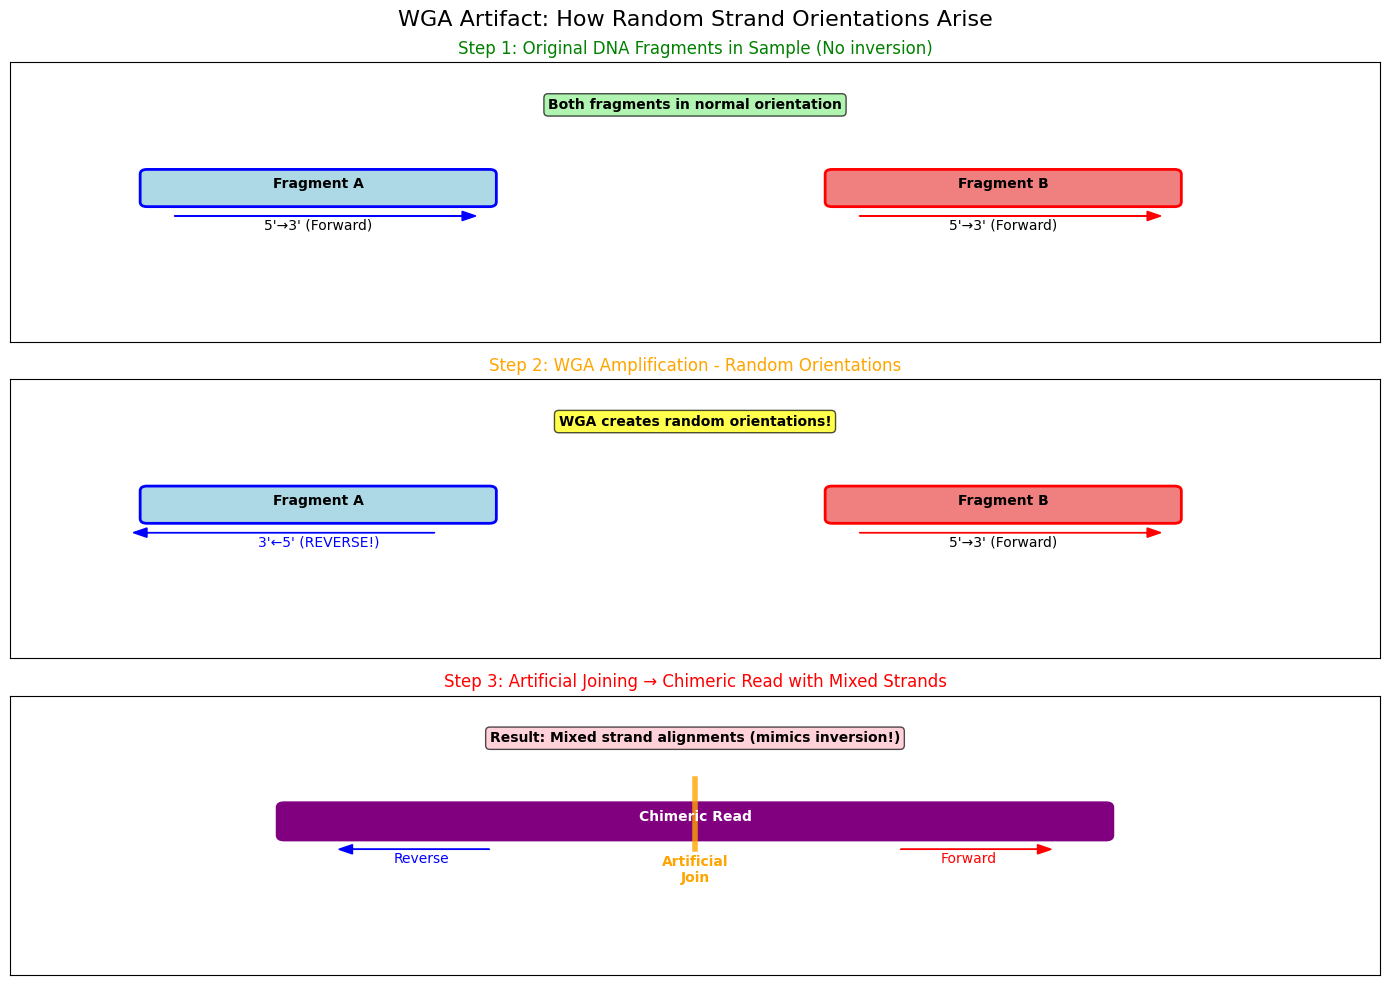

In [232]:
def explain_reverse_strand_alignment():
    """
    Explain why the primary alignment is on reverse strand
    """
    print("=== WHY PRIMARY ALIGNMENT IS REVERSE STRAND (Flag=16) ===")
    print()

    print("🧬 NANOPORE SEQUENCING REALITY:")
    print("• DNA can enter pore from either direction (5'→3' or 3'→5')")
    print("• Sequencer reads whatever direction the molecule goes")
    print("• No predetermined orientation like paired-end sequencing")
    print()

    print("🎯 ALIGNMENT PROCESS:")
    print("1. Aligner gets raw read sequence: 'ATCGATCG...'")
    print("2. Tries both orientations against reference:")
    print("   - Forward:         ATCGATCG...")
    print("   - Reverse comp:    CGATCGAT...")
    print("3. Picks best match → Primary segment matched reverse strand")
    print("4. Sets flag=16 to indicate reverse strand alignment")
    print()

    print("🔬 FOR YOUR READ:")
    print("Primary segment (bp 11-1554 of read):")
    print("  • Best match found on REVERSE strand of reference")
    print("  • Flag=16 set by aligner")
    print("  • This is just alignment orientation, not biological meaning")
    print()

    print("📊 WGA ARTIFACT EXPLANATION:")
    print("During WGA amplification:")
    print("  Fragment A: Gets amplified, random orientation")
    print("  Fragment B: Gets amplified, different random orientation")
    print("  Join: A + B = chimeric molecule with mixed orientations")
    print()
    print("  Result: Primary aligns reverse, SA aligns forward")
    print("         ↑")
    print("  This randomness supports ARTIFACT hypothesis!")
    print()

    print("🆚 REAL INVERSION vs ARTIFACT:")
    print()
    print("REAL INVERSION pattern:")
    print("  Read crosses breakpoint:")
    print("  [Normal region] → Forward strand alignment")
    print("  [Inverted region] → Reverse strand alignment")
    print("  ↑ Biologically meaningful strand flip")
    print()
    print("WGA ARTIFACT pattern:")
    print("  Fragment A: Random orientation → Reverse alignment")
    print("  Fragment B: Random orientation → Forward alignment")
    print("  ↑ Artificial, no biological meaning")
    print()

    print("🚩 RED FLAG INDICATORS:")
    print("✓ Gap between segments (489bp) - suggests separate fragments")
    print("✓ Random strand orientations - no biological pattern")
    print("✓ High soft clipping - poor alignment quality")
    print("✓ Single supporting read - no clustering")
    print("✓ 'Too perfect' breakpoints - suspicious precision")


def visualize_wga_strand_artifact():
    """
    Visual representation of how WGA creates strand artifacts
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))
    fig.suptitle("WGA Artifact: How Random Strand Orientations Arise", fontsize=16)

    # Panel 1: Original DNA fragments in sample
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 3)
    ax1.set_title("Step 1: Original DNA Fragments in Sample (No inversion)", color="green")

    # Fragment A (normal orientation)
    frag_a = patches.FancyBboxPatch(
        (1, 1.5), 2.5, 0.3, boxstyle="round,pad=0.05", facecolor="lightblue", edgecolor="blue", linewidth=2
    )
    ax1.add_patch(frag_a)
    ax1.text(2.25, 1.65, "Fragment A", ha="center", fontweight="bold")
    ax1.arrow(1.2, 1.35, 2.1, 0, head_width=0.1, head_length=0.1, fc="blue", ec="blue")
    ax1.text(2.25, 1.2, "5'→3' (Forward)", ha="center", fontsize=10)

    # Fragment B (normal orientation)
    frag_b = patches.FancyBboxPatch(
        (6, 1.5), 2.5, 0.3, boxstyle="round,pad=0.05", facecolor="lightcoral", edgecolor="red", linewidth=2
    )
    ax1.add_patch(frag_b)
    ax1.text(7.25, 1.65, "Fragment B", ha="center", fontweight="bold")
    ax1.arrow(6.2, 1.35, 2.1, 0, head_width=0.1, head_length=0.1, fc="red", ec="red")
    ax1.text(7.25, 1.2, "5'→3' (Forward)", ha="center", fontsize=10)

    ax1.text(
        5,
        2.5,
        "Both fragments in normal orientation",
        ha="center",
        fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7),
    )
    ax1.set_yticks([])
    ax1.set_xticks([])

    # Panel 2: WGA amplification with random orientations
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 3)
    ax2.set_title("Step 2: WGA Amplification - Random Orientations", color="orange")

    # Fragment A amplified in reverse
    frag_a2 = patches.FancyBboxPatch(
        (1, 1.5), 2.5, 0.3, boxstyle="round,pad=0.05", facecolor="lightblue", edgecolor="blue", linewidth=2
    )
    ax2.add_patch(frag_a2)
    ax2.text(2.25, 1.65, "Fragment A", ha="center", fontweight="bold")
    ax2.arrow(3.1, 1.35, -2.1, 0, head_width=0.1, head_length=0.1, fc="blue", ec="blue")
    ax2.text(2.25, 1.2, "3'←5' (REVERSE!)", ha="center", fontsize=10, color="blue")

    # Fragment B amplified forward
    frag_b2 = patches.FancyBboxPatch(
        (6, 1.5), 2.5, 0.3, boxstyle="round,pad=0.05", facecolor="lightcoral", edgecolor="red", linewidth=2
    )
    ax2.add_patch(frag_b2)
    ax2.text(7.25, 1.65, "Fragment B", ha="center", fontweight="bold")
    ax2.arrow(6.2, 1.35, 2.1, 0, head_width=0.1, head_length=0.1, fc="red", ec="red")
    ax2.text(7.25, 1.2, "5'→3' (Forward)", ha="center", fontsize=10)

    ax2.text(
        5,
        2.5,
        "WGA creates random orientations!",
        ha="center",
        fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
    )
    ax2.set_yticks([])
    ax2.set_xticks([])

    # Panel 3: Artificial joining creates chimeric read
    ax3.set_xlim(0, 10)
    ax3.set_ylim(0, 3)
    ax3.set_title("Step 3: Artificial Joining → Chimeric Read with Mixed Strands", color="red")

    # Joined fragments
    joined_rect = patches.FancyBboxPatch(
        (2, 1.5), 6, 0.3, boxstyle="round,pad=0.05", facecolor="purple", edgecolor="purple", linewidth=2
    )
    ax3.add_patch(joined_rect)
    ax3.text(5, 1.65, "Chimeric Read", ha="center", fontweight="bold", color="white")

    # Show different orientations
    ax3.arrow(3.5, 1.35, -1, 0, head_width=0.1, head_length=0.1, fc="blue", ec="blue")
    ax3.text(3, 1.2, "Reverse", ha="center", fontsize=10, color="blue")

    ax3.arrow(6.5, 1.35, 1, 0, head_width=0.1, head_length=0.1, fc="red", ec="red")
    ax3.text(7, 1.2, "Forward", ha="center", fontsize=10, color="red")

    # Join point
    ax3.axvline(5, ymin=0.45, ymax=0.7, color="orange", linewidth=4, alpha=0.8)
    ax3.text(5, 1.0, "Artificial\nJoin", ha="center", fontweight="bold", color="orange")

    ax3.text(
        5,
        2.5,
        "Result: Mixed strand alignments (mimics inversion!)",
        ha="center",
        fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="pink", alpha=0.7),
    )

    ax3.set_yticks([])
    ax3.set_xticks([])

    plt.tight_layout()
    return fig


# Run the analysis
if __name__ == "__main__":
    explain_reverse_strand_alignment()
    fig = visualize_wga_strand_artifact()
    plt.show()

In [ ]:
selected_read = "6f4568e5-3543-48c7-a64b-f4010c03804c"
# sv 1584378 1585940

In [38]:
def show_read_info(read):
    print(f"Read name: {read.query_name}")
    print(f"is forward: {read.is_forward}")
    print(f"Reference name: {read.reference_name}")
    print(f"Reference start: {read.reference_start}")
    print(f"Reference end: {read.reference_end}")
    print(f"Reference length: {read.reference_length}")
    print(f"Query alignment start: {read.query_alignment_start}")
    print(f"Query alignment end: {read.query_alignment_end}")
    print(f"Query alignment length: {read.query_alignment_length}")
    print(f"CIGAR string: {read.cigarstring}")
    print(f"SA tag: {read.get_tag('SA')}")

In [22]:
from typing import List, Dict, Tuple


# Complete Statistical Analysis Integration
def comprehensive_statistical_analysis(
    sequence: str,
    positions: List[int],
    window_size: int = 50,
    alpha: float = 0.05,
    correction_method: str = "bonferroni",
    show_plots: bool = True,
) -> Dict:
    """
    Perform comprehensive statistical analysis of position attention patterns.

    Args:
        sequence: DNA sequence to analyze
        positions: List of positions to test
        window_size: Size of window around each position
        alpha: Significance level
        correction_method: Method for multiple testing correction
        show_plots: Whether to display visualization plots

    Returns:
        Dictionary containing all analysis results
    """
    print("=" * 80)
    print("COMPREHENSIVE STATISTICAL ANALYSIS")
    print("=" * 80)
    print(f"Sequence length: {len(sequence)}")
    print(f"Positions to analyze: {positions}")
    print(f"Window size: {window_size}")
    print(f"Significance level: {alpha}")
    print(f"Correction method: {correction_method}")

    # Step 1: Extract attention data
    print("\n1. Extracting attention data...")
    attention_data = stat_analyzer.extract_attention_data(sequence, positions, window_size)

    # Step 2: Test position significance
    print("2. Testing position significance...")
    results = stat_analyzer.test_position_significance(attention_data, alpha)

    # Step 3: Apply multiple testing correction
    print(f"3. Applying {correction_method} correction...")
    results_corrected = stat_analyzer.multiple_testing_correction(results, correction_method)

    # Step 4: Compare positions (if more than one)
    comparison_results = None
    if len(positions) > 1:
        print("4. Comparing positions with ANOVA...")
        comparison_results = stat_analyzer.compare_positions(attention_data, alpha)
    else:
        print("4. Skipping position comparison (need at least 2 positions)")

    # Step 5: Generate report
    print("5. Generating statistical report...")
    report = stat_analyzer.generate_report(results_corrected, comparison_results)
    print(report)

    # Step 6: Create visualizations
    if show_plots:
        print("\n6. Creating visualizations...")

        # Main comparison plot
        stat_visualizer.plot_position_comparison(attention_data, results_corrected)

        # Detailed distribution plots
        stat_visualizer.plot_attention_distributions(attention_data, results_corrected)

        # ANOVA results (if available)
        if comparison_results and "error" not in comparison_results:
            stat_visualizer.plot_anova_results(attention_data, comparison_results)

    # Return comprehensive results
    return {
        "attention_data": attention_data,
        "results_uncorrected": results,
        "results_corrected": results_corrected,
        "comparison_results": comparison_results,
        "report": report,
        "parameters": {
            "sequence_length": len(sequence),
            "positions": positions,
            "window_size": window_size,
            "alpha": alpha,
            "correction_method": correction_method,
        },
    }


# Test with the current read data
def test_statistical_analysis_with_current_read(read):
    """Test the statistical analysis with the current chimeric read."""

    # Get the current read data
    if isinstance(read, pd.Series):
        read_name, test_sequence, biological_positions = read["read_name"], read["seq"], read["pos"]
        biological_positions = [int(i) for i in biological_positions.lstrip("[").rstrip("]").split(",")]
    else:
        read_name, test_sequence, biological_positions = get_sequence_and_pos(read)

    print(f"Testing with read: {read_name}")
    print(f"Sequence length: {len(test_sequence)}")
    print(f"Biological positions: {biological_positions}")
    print(f"Sequence preview: {test_sequence[:100]}...")

    # Perform comprehensive analysis
    results = comprehensive_statistical_analysis(
        sequence=test_sequence,
        positions=biological_positions,
        window_size=100,  # ±50 nucleotides around each position
        alpha=0.05,
        correction_method="bonferroni",
        show_plots=True,
    )

    return results

In [29]:
# selected
# 8d99362e-b348-4031-b55a-cd2fb4ef43a3
# c938cba2-6cbd-4f98-bfa2-03ec43f631a8


# 6f4568e5-3543-48c7-a64b-f4010c03804c
# 1c66d41b-de5a-4e3d-b54d-69d41bfc3160
# aed3bcc2-4e60-487d-afc5-8393918ef92d_1

Testing comprehensive statistical analysis...


Unnamed: 0                                                   18
read_name                  1c66d41b-de5a-4e3d-b54d-69d41bfc3160
sv_type                                                     INV
seq           AAGGCCATGGTGCTGGAGGAGCTCCCCGGCTCCGGGGCTGTGGCCC...
pos                                                   [0, 2148]
Name: 18, dtype: object

Testing with read: 1c66d41b-de5a-4e3d-b54d-69d41bfc3160
Sequence length: 2802
Biological positions: [0, 2148]
Sequence preview: AAGGCCATGGTGCTGGAGGAGCTCCCCGGCTCCGGGGCTGTGGCCCAGAAAGACGCCCCAGGGTGGCACTCAGACAGTGAGGTGGCCCTCTTGACCCCAC...
COMPREHENSIVE STATISTICAL ANALYSIS
Sequence length: 2802
Positions to analyze: [0, 2148]
Window size: 100
Significance level: 0.05
Correction method: bonferroni

1. Extracting attention data...
{'Biological': '0.420', 'Chimeric Artifact': '0.580'}
2. Testing position significance...
3. Applying bonferroni correction...
4. Comparing positions with ANOVA...
5. Generating statistical report...
STATISTICAL ANALYSIS REPORT

1. POSITION SIGNIFICANCE TESTS
--------------------------------------------------

Position 0 (Unknown):
  Position vs Background (Z-test):
    - Position attention: 0.0002
    - Background mean: 0.0004 ± 0.0004
    - Z-score: -0.33
    - P-value: 0.7381
    - P-value (corrected): 1.0000
    - Significant: No
  Window vs Background:
    - Wind

/var/folders/s3/vs6nrrg52sdfjk3z90p7ndt94gg4tq/T/ipykernel_10025/3521194183.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(position_data_for_box, labels=position_labels, patch_artist=True)


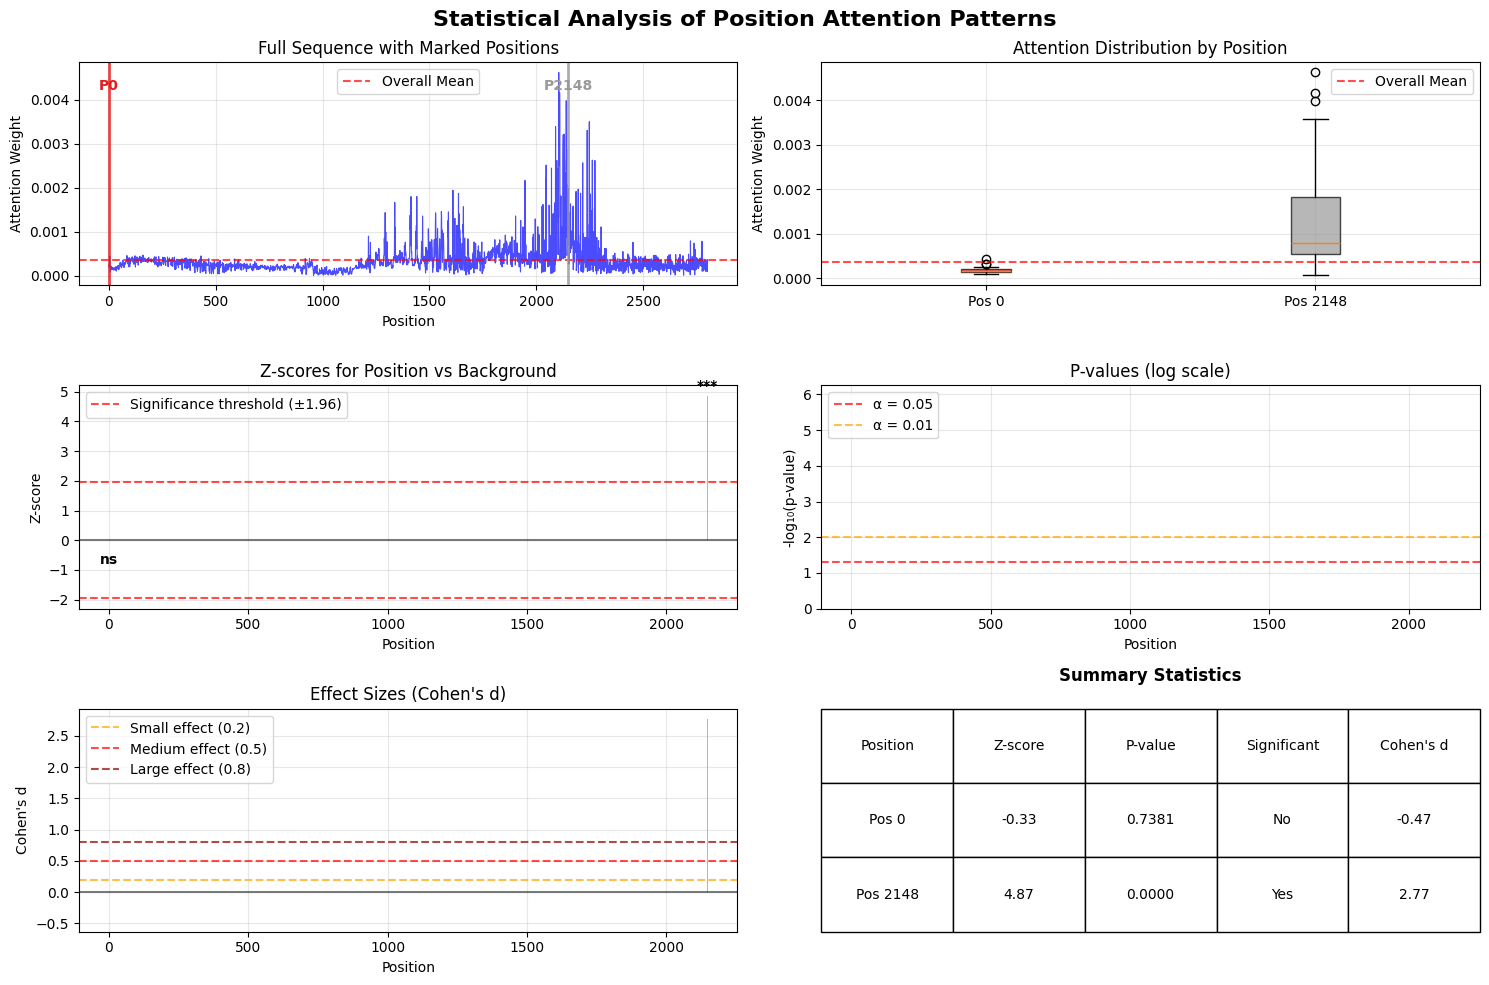

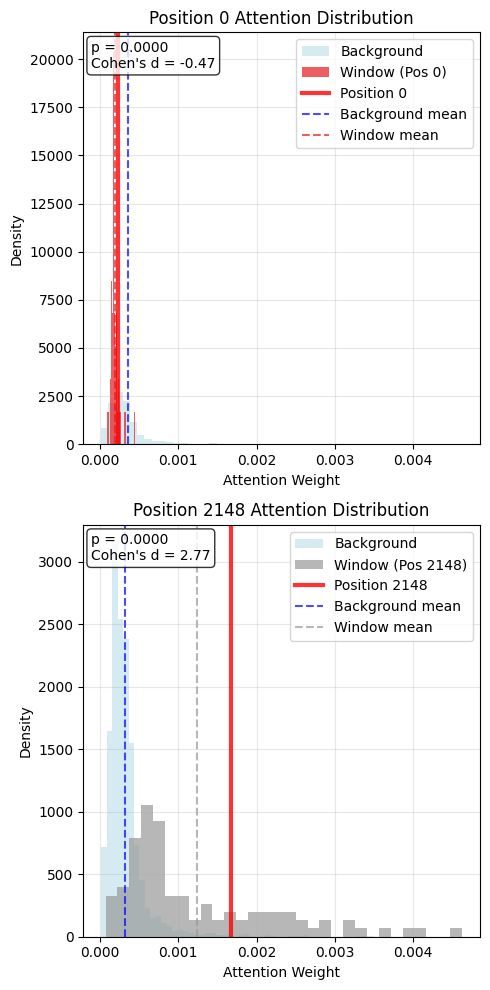

/var/folders/s3/vs6nrrg52sdfjk3z90p7ndt94gg4tq/T/ipykernel_10025/3521194183.py:317: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels([comp.replace("_vs_", " vs ") for comp in comparisons], rotation=45)


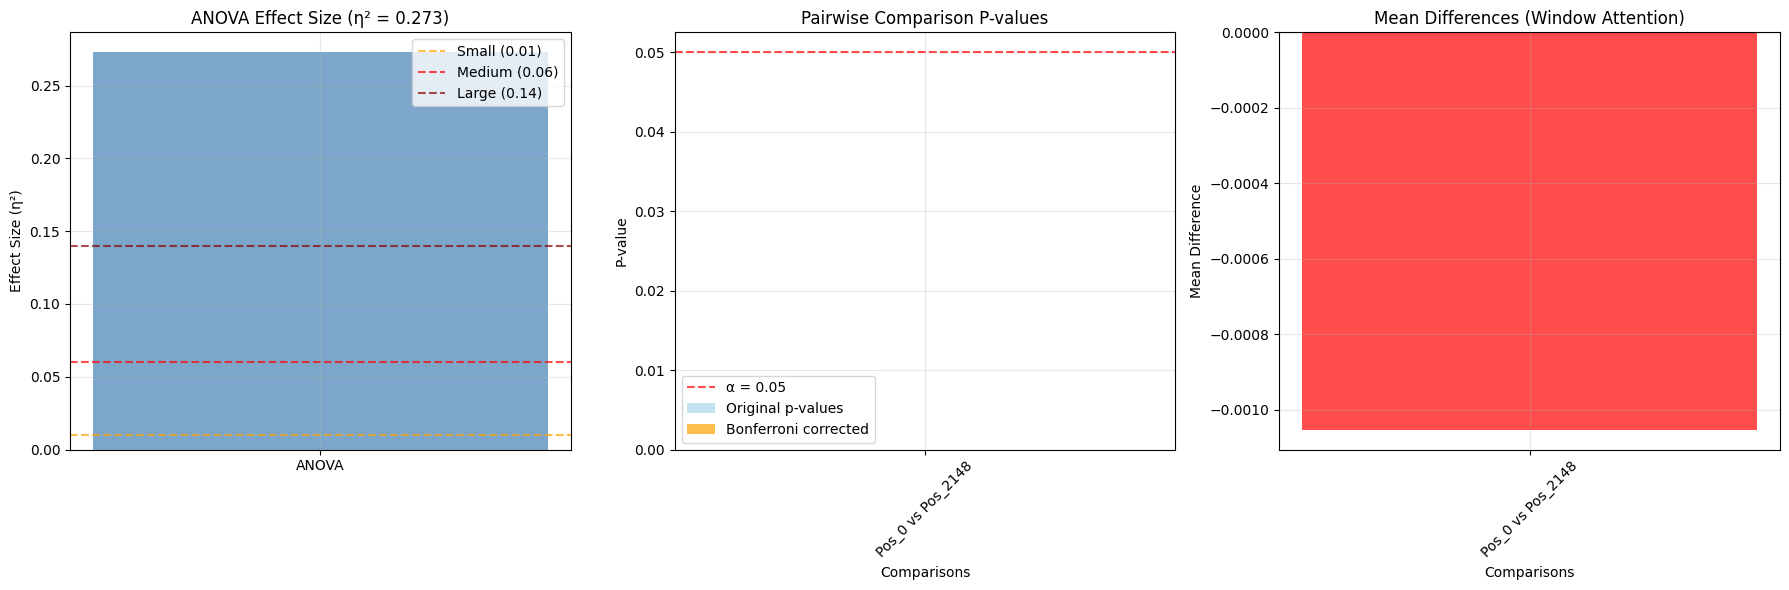

In [37]:
# Run the test
print("Testing comprehensive statistical analysis...")
# read = next(chimeric_reads)
# read = next(inv_filter_mk1c_vcf_df_iterator)

selected_read = "1c66d41b-de5a-4e3d-b54d-69d41bfc3160"
selected_read = mk1c_vcf_df[mk1c_vcf_df.read_name == selected_read].iloc[0, :]
selected_read
statistical_results = test_statistical_analysis_with_current_read(selected_read)

In [ ]:
statistical_results

{'attention_data': {'position_data': {11: {'position_attention': np.float32(0.00022335378),
    'window_attention': array([1.04425482e-04, 2.84266891e-04, 2.82730616e-04, 3.43687192e-04,
           3.59809084e-04, 2.72972800e-04, 1.32870249e-04, 2.06082841e-04,
           2.05535835e-04, 2.12835716e-04, 2.17557143e-04, 2.23353782e-04,
           2.49320554e-04, 2.30576174e-04, 2.45793228e-04, 2.32657243e-04,
           1.57243383e-04, 2.44401162e-04, 1.65639794e-04, 1.04689374e-04,
           1.63854682e-04, 1.78604430e-04, 1.56880298e-04, 2.06633194e-04,
           1.30903631e-04, 2.56929372e-04, 2.03078569e-04, 2.63991271e-04,
           1.96375768e-04, 1.59200456e-04, 1.27224921e-04, 1.39159107e-04,
           1.36968883e-04, 1.54164198e-04, 1.67488586e-04, 2.15070817e-04,
           2.70109071e-04, 2.75442901e-04, 2.36926469e-04, 1.91032173e-04,
           2.42584108e-04, 2.85523885e-04, 2.24505318e-04, 1.64232886e-04,
           1.83299431e-04, 2.31465980e-04, 1.88331949e-04, 2.71

In [ ]:
def save_statistical_results(statistical_results, file_path):
    import pickle

    with open(file_path, "wb") as f:
        pickle.dump(statistical_results, f)


save_statistical_results(statistical_results, "../data/6f4568e5-3543-48c7-a64b-f4010c03804c_attention.pkl")

In [23]:
# mk1c:  /gpfs/projects/b1171/qgn1237/4_single_cell_SV_chimera/20250904_formal_publish_figures/2_artifacts_reads_supporting_SV_type_in_Set_A/hyena_p2_765108_bulk_model_on_mk1c_dataset_setA/sniffles_PC3_10_cells_MDA_Mk1c_dirty.vcf

from pathlib import Path


def load_chimeric_read_supported_sv(vcf_file: Path):
    results = {}

    with open(vcf_file) as reader:
        for line in reader:
            if line.startswith("#"):
                continue
            content = line.strip().split()
            info = content[7]
            values = info.split(";")
            values_dict = {}
            for value in values:
                if "=" in value:
                    key, val = value.split("=")
                    values_dict[key] = val

            for rname in values_dict["RNAMES"].split(","):
                results[rname] = values_dict["SVTYPE"]

    return results


def fetch_seq(chimeric_iterator):
    result = {}
    result_reads = {}

    for read in chimeric_iterator:
        result[read.query_name] = get_sequence_and_pos(read)
        result_reads[read.query_name] = read
    return result, result_reads

    # return read.query_name, read.query_sequence, [read.query_alignment_start, read.query_alignment_end - 1]

In [24]:
mk1c_vcf_df = pd.read_csv("../data/sv/mk1c_vcf_df.csv")

In [25]:
mk1c_vcf_df

,Unnamed: 0,read_name,sv_type,seq,pos
0,0,af153a9f-86eb-40ad-b290-0ae4e4dc0410_1,INV,TGGATCACCTGAGGTCAGGAGTTTGAGACCAGCCTGGCCAACATGG...,"[267, 2144]"
1,1,4ca68df2-89e2-48fb-a8cc-e8670863380a,DEL,NaN,NaN
2,2,f717d358-0323-4f72-993e-f7ef14cef741,DEL,NaN,NaN
3,3,feb14913-f81c-46b2-9dc4-000b2f4b2577,DEL,GTCTATTCTTATATGATATATGTATCATATTCTGTGATCTATATGT...,"[2409, 3693]"
4,4,107582e6-3940-4fa9-bf1e-5ba164a44033,DEL,NaN,NaN
...,...,...,...,...,...
449168,449168,50b63543-36e1-4842-9f7a-4a3046e36e41,DEL,NaN,NaN
449169,449169,9017c6ff-8f71-4499-92d2-79de612a1180,DEL,TTGTCCACCACCGGCCACAAAGAGCTCCAAATAACCAGTTGCAGAT...,"[17, 5668]"
449170,449170,9db50a07-4e29-4b57-a524-a73dca6ce7f4,INV,CAACGCATTGGCTTCTGCAAACTGATTTGGAGCAATTTGAAGCCTG...,"[576, 1614]"
449171,449171,df2397a8-74c0-4fba-bfc7-89bcd83b0ccf,INS,NaN,NaN


In [186]:
mk1c_vcf_path = "/gpfs/projects/b1171/qgn1237/4_single_cell_SV_chimera/20250904_formal_publish_figures/2_artifacts_reads_supporting_SV_type_in_Set_A/hyena_p2_765108_bulk_model_on_mk1c_dataset_setA/sniffles_PC3_10_cells_MDA_Mk1c_dirty.vcf"

In [34]:
mk1c_read_with_sv = load_chimeric_read_supported_sv(mk1c_vcf_path)

In [35]:
mk1c_read_with_sv

{'af153a9f-86eb-40ad-b290-0ae4e4dc0410_1': 'INV',
 '4ca68df2-89e2-48fb-a8cc-e8670863380a': 'DEL',
 'f717d358-0323-4f72-993e-f7ef14cef741': 'DEL',
 'feb14913-f81c-46b2-9dc4-000b2f4b2577': 'DEL',
 '107582e6-3940-4fa9-bf1e-5ba164a44033': 'DEL',
 'c7b74a80-2816-4f01-874a-134f531ba822': 'INV',
 '6677e2b4-5333-478e-afd9-64c8ee2bdc94': 'INV',
 '7da070b7-cffe-4b9a-9f4a-5f0e60459f57': 'DUP',
 '13faaf94-5a40-40ab-99fe-60efed3335ab': 'INV',
 'cf1cfa9f-16a4-44bf-ad9f-f6568439081b': 'INV',
 'ba3797a9-e03b-411a-9984-0730cbd66d37': 'DEL',
 'e77679b3-b592-4a61-a1e2-66700852eb02': 'INV',
 '391e5b62-b3e5-4b98-b87b-01241ef7fc35': 'DEL',
 'b7e1b114-c939-4709-8d7d-dcab7531e8fc_1': 'INV',
 '5e4f2436-288f-42a3-9bf4-87a374fb9667_3': 'INV',
 'bb88091f-da8f-4b6a-b1ee-0c6e29a438e6': 'DEL',
 '60d8cd26-204e-4873-9cba-888abe947470': 'INV',
 'd4db5906-8d3e-4965-a281-fd6083fdc0ea': 'INV',
 '1c66d41b-de5a-4e3d-b54d-69d41bfc3160': 'INV',
 'cbe3369c-2b94-4bd5-88e3-df871422cd37': 'DEL',
 'e9be0649-b13a-4b41-94f3-c8f2c0ec

In [44]:
mk1c_vcf_df = pd.DataFrame(list(mk1c_read_with_sv.items()), columns=["read_name", "sv_type"])

In [46]:
mk1c_vcf_df

,read_name,sv_type
0,af153a9f-86eb-40ad-b290-0ae4e4dc0410_1,INV
1,4ca68df2-89e2-48fb-a8cc-e8670863380a,DEL
2,f717d358-0323-4f72-993e-f7ef14cef741,DEL
3,feb14913-f81c-46b2-9dc4-000b2f4b2577,DEL
4,107582e6-3940-4fa9-bf1e-5ba164a44033,DEL
...,...,...
449168,50b63543-36e1-4842-9f7a-4a3046e36e41,DEL
449169,9017c6ff-8f71-4499-92d2-79de612a1180,DEL
449170,9db50a07-4e29-4b57-a524-a73dca6ce7f4,INV
449171,df2397a8-74c0-4fba-bfc7-89bcd83b0ccf,INS


,Unnamed: 0,read_name,sv_type,seq,pos
0,0,af153a9f-86eb-40ad-b290-0ae4e4dc0410_1,INV,TGGATCACCTGAGGTCAGGAGTTTGAGACCAGCCTGGCCAACATGG...,"[267, 2144]"
1,1,4ca68df2-89e2-48fb-a8cc-e8670863380a,DEL,NaN,NaN
2,2,f717d358-0323-4f72-993e-f7ef14cef741,DEL,NaN,NaN
3,3,feb14913-f81c-46b2-9dc4-000b2f4b2577,DEL,GTCTATTCTTATATGATATATGTATCATATTCTGTGATCTATATGT...,"[2409, 3693]"
4,4,107582e6-3940-4fa9-bf1e-5ba164a44033,DEL,NaN,NaN
...,...,...,...,...,...
449168,449168,50b63543-36e1-4842-9f7a-4a3046e36e41,DEL,NaN,NaN
449169,449169,9017c6ff-8f71-4499-92d2-79de612a1180,DEL,TTGTCCACCACCGGCCACAAAGAGCTCCAAATAACCAGTTGCAGAT...,"[17, 5668]"
449170,449170,9db50a07-4e29-4b57-a524-a73dca6ce7f4,INV,CAACGCATTGGCTTCTGCAAACTGATTTGGAGCAATTTGAAGCCTG...,"[576, 1614]"
449171,449171,df2397a8-74c0-4fba-bfc7-89bcd83b0ccf,INS,NaN,NaN


In [86]:
chimeric_seqs = fetch_seq(chimeric_reads)

In [51]:
len(chimeric_seqs)

1666427

In [97]:
mk1c_vcf_df["seq"] = [
    chimeric_seqs[read][1] if chimeric_seqs.get(read) is not None else np.nan for read in mk1c_vcf_df.read_name
]
mk1c_vcf_df["pos"] = [
    chimeric_seqs[read][2] if chimeric_seqs.get(read) is not None else np.nan for read in mk1c_vcf_df.read_name
]

In [98]:
mk1c_vcf_df

,read_name,sv_type,seq,pos
0,af153a9f-86eb-40ad-b290-0ae4e4dc0410_1,INV,TGGATCACCTGAGGTCAGGAGTTTGAGACCAGCCTGGCCAACATGG...,"[267, 2144]"
1,4ca68df2-89e2-48fb-a8cc-e8670863380a,DEL,NaN,NaN
2,f717d358-0323-4f72-993e-f7ef14cef741,DEL,NaN,NaN
3,feb14913-f81c-46b2-9dc4-000b2f4b2577,DEL,GTCTATTCTTATATGATATATGTATCATATTCTGTGATCTATATGT...,"[2409, 3693]"
4,107582e6-3940-4fa9-bf1e-5ba164a44033,DEL,NaN,NaN
...,...,...,...,...
449168,50b63543-36e1-4842-9f7a-4a3046e36e41,DEL,NaN,NaN
449169,9017c6ff-8f71-4499-92d2-79de612a1180,DEL,TTGTCCACCACCGGCCACAAAGAGCTCCAAATAACCAGTTGCAGAT...,"[17, 5668]"
449170,9db50a07-4e29-4b57-a524-a73dca6ce7f4,INV,CAACGCATTGGCTTCTGCAAACTGATTTGGAGCAATTTGAAGCCTG...,"[576, 1614]"
449171,df2397a8-74c0-4fba-bfc7-89bcd83b0ccf,INS,NaN,NaN


In [89]:
mk1c_vcf_df.to_csv("../data/sv/mk1c_vcf_df.csv")

In [104]:
filter_mk1c_vcf_df = mk1c_vcf_df[~mk1c_vcf_df.seq.isnull()]

In [106]:
inv_filter_mk1c_vcf_df = filter_mk1c_vcf_df.query('sv_type == "INV"')

In [119]:
inv_filter_mk1c_vcf_df_iterator = (row for ind, row in inv_filter_mk1c_vcf_df.iterrows())

In [116]:
isinstance(row, pd.Series)

True